Link to Google Colab: https://colab.research.google.com/drive/18jiKfrXCgIkBUVg7suudREiLLtBeHJMy?usp=sharing


In [1]:
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00


In [2]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch
from torch.optim import Adam
from torch import nn
from datasets import load_dataset
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import models
from torchvision import transforms
import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm
from PIL import Image

### Part 1. On attention [2 points]

Answer each question in max. 3 lines. Points will be subtracted for long answers so be short and precise. Add your explanations in the below box - NO added handwritten images, write in latex!

1. [0.5 point] You are given an input $X=[x_1,...,x_L]$ (e.g. a sentence of tokenised words). Your goal is to predict the next token $x_i$ conditional on $x_{1},...,x_{i}$. In other words, the $i$-th position can only be influenced by a position $j$ if and only if $j \leq i$, namely a position cannot be influenced by the subsequent positions. \\
    a. What would be the problem when passing $X$ through attention? Explain using the computations that attention performs, e.g. you can write out the matrix multiplication. \\
    b. How could you ensure that the prediction for position $i$ depends solely on positions $j\leq i$? Hint: what in the attention computation should be masked & in what way?
2. [0.5 point] Let's consider multi-head attention. How does multi-head attention change the computations inside the softmax (the $QK^T$ term) and the product with $V$ and why could this be beneficial to learning?
3. [0.5 point] Remember that standard attention is given by
\begin{align}
Q &= XW^Q \\
K&=XW^K \\
V&=XW^V \\
A(X) &= \text{softmax}\left(\frac{QK^T}{\sqrt{D}}\right)V
\end{align}
for a sequence $X\in\mathbb{R}^{L\times D}$ with $L$ the sequence length.
What is the memory and computational cost of attention in terms of the sequence length and where does this come from?
4. [0.5 point] A big focus these days is on making attention more computationally efficient. The $i$-th row (as a vector) of attention can be rewritten as,
\begin{align}
A(X)_i = \frac{\sum_{j=1}^L sim(Q_i,K_j)V_j}{\sum_{j=1}^L sim(Q_i,K_j)},
\end{align}
with $sim(q,k)=exp(q^Tk/\sqrt{D})$.
Linear attention would be given by,
\begin{align}
A(X)_i = \frac{\sum_{j=1}^L \phi(Q_i)^T\phi(K_j)V_j}{\sum_{j=1}^L\phi(Q_i)^T\phi(K_j)}.
\end{align}
Explain the relation between regular attention and linear attention (i.e. what kind of similarity function does linear attention assume and how is the approximation made?) & how the above expression can be rewritten and use this to explain why linear attention computation can be done more efficiently compared to standard attention.

Fill in your answers below.

1. a. The standard attention formula requires us to calculate $QK^T$. However,
$$[QK^T]_{i,j} = \sum_{k=1}^DQ_{i,k}K_{j,k}$$
$$ = \sum_{k=1}^D\left(\left( \sum_{l=1}^DX_{i,l}W^Q_{l,k}\right)\left( \sum_{m=1}^DX_{j,m}W^K_{m,k}\right)\right)$$
shows clearly that the first row of $QK^T$ depends on later entries of $X$. Therefore, there is dependence on other rows and columns of $X$, which does not satisfy the required condition of later positions not afftecting the current position. \\
b. We can apply a mask to the $QK^T$ computation before softmax by setting each $(i,j)$ entry to $-\infty$ for all $j>i$. Therefore, after softmax, all these corresponding future weights would be set to $0$, giving us a lower triangular matrix.

2. Multi-head attention splits $Q$, $K$, and $V$ into many heads and computes parallel attention computations. Each head computes its own $QK^T$, scales it by the corresponding diagonal entry of $D$, and applies a softmax function, resulting in different sets of attention weights. Multiplying these weights with $V$ results in a weighted sum of the weights. With multiple heads, the model is less likely to overfit to specific trends and can generalise better to unseen data by taking advantage of a more diverse input.

3.
$$Q, K, V \in \mathbb{R}^{L\times D},$$
$$ QK^T \in \mathbb{R}^{L \times L}.$$
Therefore, the bulk of the computional cost results from the matrix multiplication of $\text{softmax}(QK^T)$ and $V$ which is $O(L^2D)$. The softmax function itself has a complexity cost of $O(L^2)$ because softmax is applied on all the $L^2$ elements in $QK^T$, which is much lower than the matrix multiplication, allowing us to ignore this term, giving the overall computational cost complexity to be $O(L^2D)$. The cost of storing the largest matrix $QK^T$ is $O(L^2)$, which is the complexity of the total memory cost .

4. Linear attention uses a similarity function that is the product of feature transformations $\phi(Q_i)^T\phi(K_j)$, where similarity is determined by orthogonality of the $Q_i$ and $K_j$ ($0$ being orthogonal and $|1|$ being identical), which is much less complex than taking an exponential like in the standard attention formula.
We can rewrite the standard attention formula using a Taylor expansion for $e^x$ which is equal to $1+x+\frac{x^2}{2!}+...$ , giving us $sim(q, k) \approx 1 + \frac{q^T k}{\sqrt{D}}$ and therefore
$$ A(X)_i \approx \frac{\sum_{j=1}^L \left(1 + \frac{Q_i^T K_j}{\sqrt{D}}\right)V_j}{\sum_{j=1}^L \left(1 + \frac{Q_i^T K_j}{\sqrt{D}}\right)}
$$
This significantly reduces the computational cost of attention calculation compared to softmax to $O(L^2D)$ because of the dot product, whereas the linear attention is of complexity $O(LD^2)$ ($L$ is normally larger than $D$ as $D$ represents the dimensionality of the feature vectors and $L$ is the length of the sequence).

### Part 2. On diffusion models [12 points]

We will be implementing a diffusion model. We will follow mostly the setup as done here: https://arxiv.org/pdf/2006.11239.pdf so please refer to this work for more details if needed.

Your goal will be to implement the code for the diffusion model, find the right configuration to train the model, achieve good accuracy and efficiency and finally interpret how the model learns. You will be marked on clean code, concise answers and good results.

We will be working with the FashionMNIST dataset. You can load the data using the below code.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [4]:
IMG_SIZE = 28
BATCH_SIZE = 128

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
channels = 1

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# Select a subset of the transformed dataset
# Did some testing with smaller/larger subsets
# Number of samples to include in the subset
num_samples = 10000
# Assuming sequential selection for simplicity
subset_indices = range(num_samples)

subset_dataset = transformed_dataset["train"].select(subset_indices)
# We can change input to subset if want
dataloader = DataLoader(transformed_dataset["train"], batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

The following helper functions will be useful. In particular, whenever we input a vector (list) of values, this will help to select the right time t output. We will use this in the sampling loops.

In [5]:
def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

##### 1. The noising process [2 points]

[1.5 pts] Our first step will be to implement the forward process that adds noise to an image.

We will be adding noise according to a linear schedule, i.e. the noises $\beta_t$, $t=1,...,T$ will come from an equally spaced vector. Implement the `linear_beta_schedule` function. Remember $\alpha_t = 1-\beta_t$ and $\bar \alpha_t = \prod_{s=1}^t \alpha_s$.

Remember that we have the closed-form solutions for the image at time $t$. Use those in the implementation of `forward_diffusion_sample` instead of a for loop over each noising step. This means you will need to implement `sqrt_one_minus_alphas_cumprod` which represents $\sqrt{1-\bar\alpha_t}$ and `sqrt_alphas_cumprod` which represents $\sqrt{\bar\alpha_t}$.

Test the function on an image from the dataset using the given code below.

In [6]:
def forward_diffusion_sample(x_0_batch, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device='cpu'):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    Hint: use the get_index_from_list function to select the right values at time t.
    """
    sqrt_alpha_cumprod = get_index_from_list(sqrt_alphas_cumprod, t, x_0_batch.shape).to(device)
    sqrt_one_minus_alpha_cumprod = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0_batch.shape).to(device)
    # Using formula from notes
    cov = sqrt_one_minus_alpha_cumprod
    mean = sqrt_alpha_cumprod * x_0_batch.to(device)
    # Add mean and noise
    img = torch.normal(mean, cov).to(device)
    noise = img.to(device) - x_0_batch.to(device)
    return img.to(device), noise.to(device)


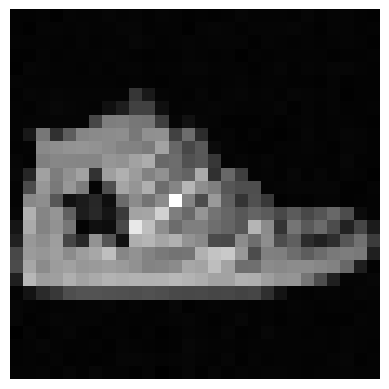

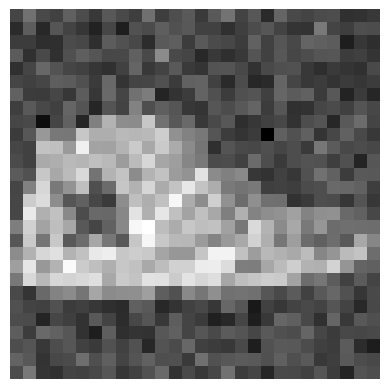

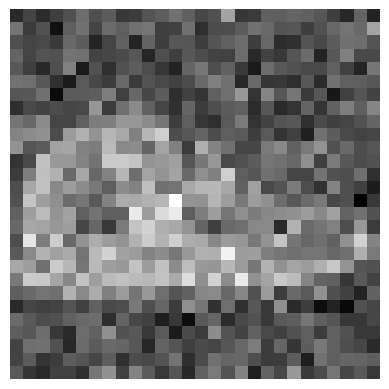

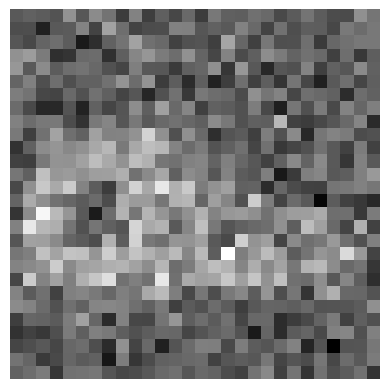

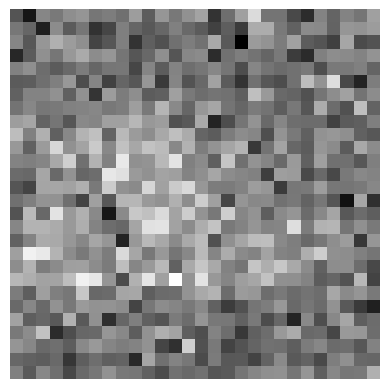

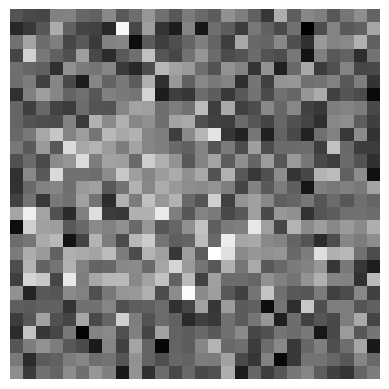

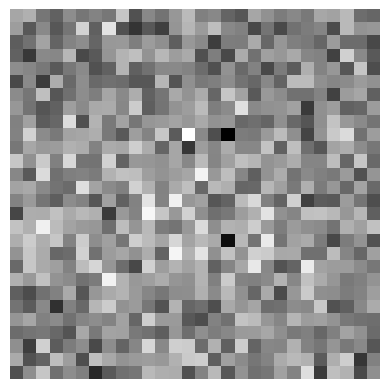

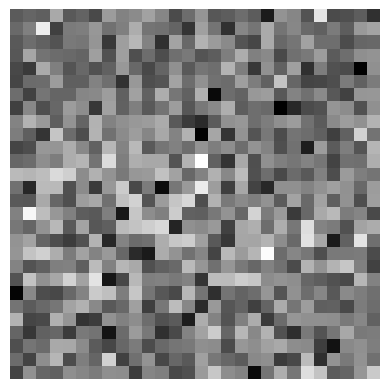

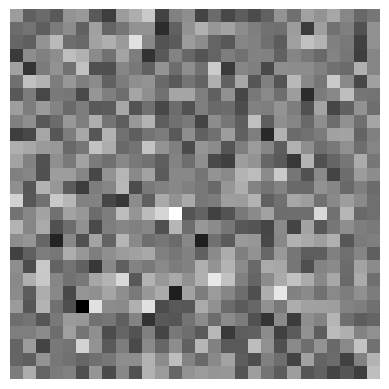

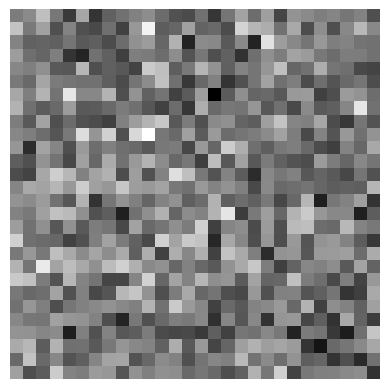

In [7]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    '''
    output a vector of size timesteps that is equally spaced between start and end; this will be the noise that is added in each time step.
    '''
    return torch.linspace(start, end, timesteps)


# Define beta schedule
T = 300
num_images = 10
def params(T):
    betas = linear_beta_schedule(timesteps=T)

    # Pre-calculate different terms for closed form
    # ADD HERE THE COMPUTATIONS NEEDED for sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
    stepsize = int(T/num_images)
    return betas, alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, stepsize

betas, alphas, alphas_cumprod, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, stepsize = params(T)
# Simulate forward diffusion
batch = next(iter(dataloader))["pixel_values"]
num_images = 10


for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    img, noise = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    plt.imshow(img.reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.show()


[0.5 pt] Play around with the noise (compare two different beta schedules), present results for the two settings and discuss (in max. 3 lines) how the hyperparameters change the forward sampling.

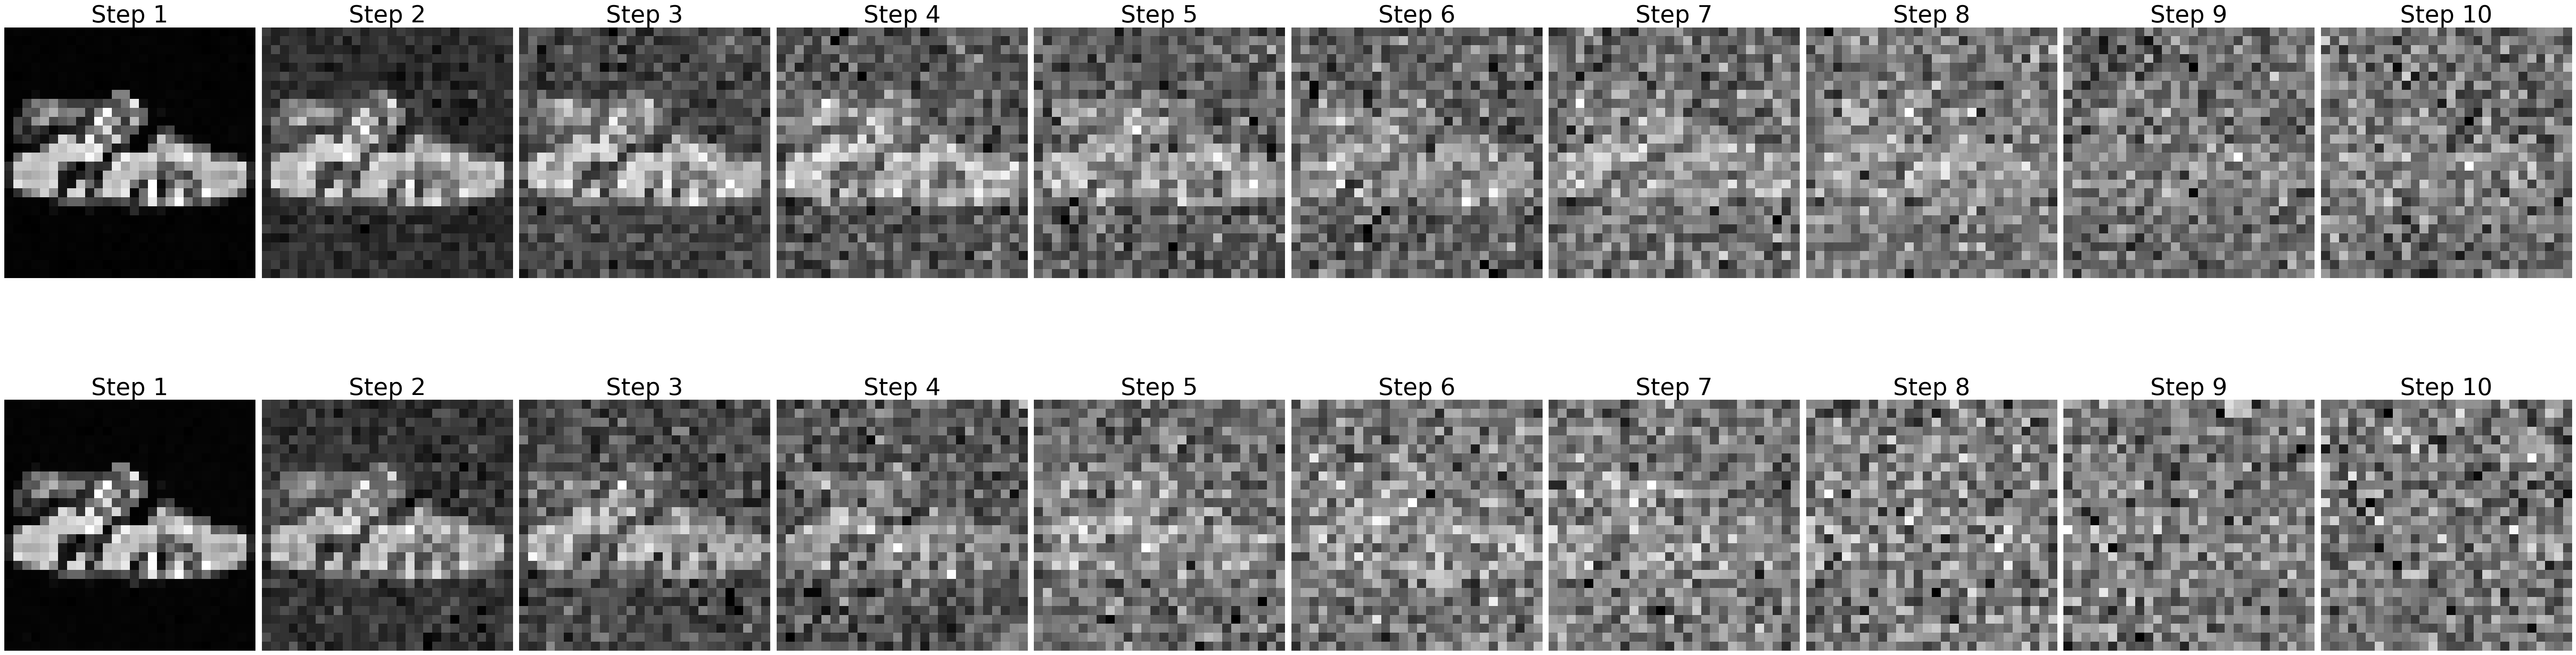

In [ ]:
# Define beta schedule
T_2 = 200
T_3 = 400

_,_,_, sqrt_alphas_cumprod_2, sqrt_one_minus_alphas_cumprod_2, stepsize_2 = params(T_2)
_,_,_, sqrt_alphas_cumprod_3, sqrt_one_minus_alphas_cumprod_3, stepsize_3 = params(T_3)

# Simulate forward diffusion
torch.manual_seed(42)
batch = next(iter(dataloader))["pixel_values"]
num_images = 10

# Create a figure and an array of axes
fig, axs = plt.subplots(2, num_images, figsize=(60, 20))


for i, idx in enumerate(range(0, T_2, stepsize_2)):
    t = torch.Tensor([idx]).type(torch.int64)
    img, noise = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod_2,
                                          sqrt_one_minus_alphas_cumprod_2)
    axs[0][i].imshow(img.reshape(28, 28), cmap="gray")
    axs[0][i].set_title(f'Step {i+1}', fontsize=40)
    axs[0][i].axis("off")

for i, idx in enumerate(range(0, T_3, stepsize_3)):
    t = torch.Tensor([idx]).type(torch.int64)
    img, noise = forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod_3,
                                          sqrt_one_minus_alphas_cumprod_3)
    axs[1][i].imshow(img.reshape(28, 28), cmap="gray")
    axs[1][i].set_title(f'Step {i+1}', fontsize=40)
    axs[1][i].axis("off")
plt.tight_layout()
plt.show()

Here, I have chosen to use a linear beta schedule which takes values between $0.0001$ and $0.02$, with the value of $T$ being set to $200$ (top row) and $400$ (bottom row). We see that at $T=200$, the image is not completely noised even at Step $10$, as the middle section is slightly brighter than the top and bottom. This is because the the variance of the distribution of the noise is higher for a larger value of $T$, therefore converges faster to a $0$-mean noise.

##### 2. The model for the noise [4 points]

We use a simple form of a UNet to predict the noise in the image. The input into the neural network will be a noisy image and the ouput from the model will be the noise in the image. It is important to also pass in the timestep into the neural network (so the model knows at which time we want to denoise the image) and we do this by passing it through a sinusoidal position embedding.

[0.5pt] Write code for the Sinusoidal Position Embedding. This should output a matrix $PE$ of size `[timesteps, dimension]` with elements:

\begin{align}
&PE_{pos,2i} = \sin\left(\frac{pos}{10000^{2i/dim}}\right),\\
&PE_{pos,2i+1} = \cos\left(\frac{pos}{10000^{2i/dim}}\right),
\end{align}
where `pos` refers to the time position and `i` refers to the dimension position and `dim` the total dimension we are working with.

Use however the following identity to implement:
\begin{align}
\frac{pos}{10000^{2i/dim}} = \exp\left(\log(pos) - \frac{2i}{dim}\log(10000)\right).
\end{align}

In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        '''
        Fill in the code
        '''
        # Initialise array
        ans = torch.zeros(time.shape[0], self.dim)
        # Create time range
        pos = torch.arange(time.shape[0]).unsqueeze(1)
        # Create the second term in the exponential
        term_2 = torch.exp(-(torch.arange(0,self.dim, 2)/self.dim) * np.log(10000))
        # Fill in the odd and even entries
        ans[:, 1::2] = torch.cos(pos*term_2)
        ans[:, ::2] = torch.sin(pos*term_2)
        return ans.to(device)

[0.5pt] Visualise the positional embeddings with arbitary time and dimension and discuss what position embeddings do (why do we add them, why this particular embedding structure) in max. 3 lines.

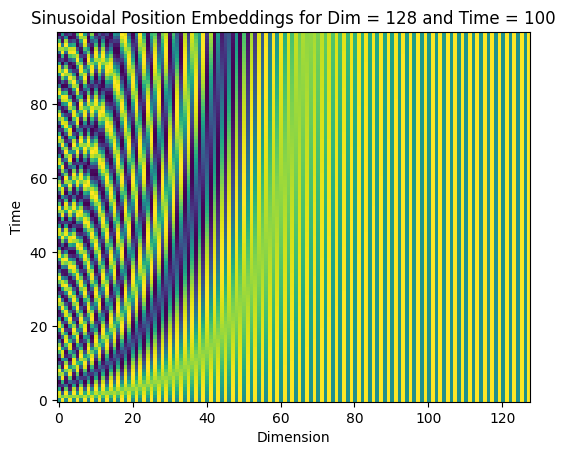

In [ ]:
# Write here the code to visualise the positional embedding
test_SPE = SinusoidalPositionEmbeddings(128)
# Visualise image
plt.imshow(test_SPE.forward(torch.tensor([i for i in range(100)]).to(device)), origin='lower')
plt.ylabel("Time")
plt.xlabel("Dimension")
plt.title("Sinusoidal Position Embeddings for Dim = 128 and Time = 100")
plt.show()

The embeddings initially take various pixel values and output a number based on the sinusoidal embedding. Over training rounds and time, pixels that are correlated with each other end up having a similar positional embedding. Positional embeddings provide models the ability to understand sequence order since the model's self-attention mechanism is does not take into account the position. The sinusoidal nature allows the model to easily learn to attend by relative positions, since for any fixed offset $k, PE_{pos+k}$ can be represented as a linear function of $PE_{pos},$ enabling the model to generalise and understand the positional relationships in longer time series data not seen during training.

Below is the code for a Block, that will make up the final UNet.

[0.5pt] Fill in the missing parts.

Remember that in the UNet architecture, we have a downsampling phase and an upsampling phase. Depending on which phase we are in, we need to make use of the up or down-sample operations.

[0.5pt] Add here an explanation as to what the block does including the up and downsample operations in maximum 3 lines:

Explanation of a Block: The block makes use of a time_mlp which encodes the output as a function of the spatial input and the temporal information

In [4]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        '''
        in_ch refers to the number of channels in the input to the operation and out_ch how many should be in the output
        '''
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        '''
        Define the forward pass making use of the components above.
        Time t should get mapped through the time_mlp layer + a relu
        The input x should get mapped through a convolutional layer with relu / batchnorm
        The time embedding should get added the output from the input convolution
        A second convolution should be applied and finally passed through the self.transform.
        '''
        time_emb = self.time_mlp(t)
        time_emb = self.relu(time_emb)
        # print(x.shape, time_emb.shape)
        x = self.conv1(x)
        # print(x.shape, time_emb.shape)
        x = self.relu(x)
        # print(x.shape, time_emb.shape)
        x = self.bnorm1(x)

        x = x + time_emb.unsqueeze(-1).unsqueeze(-1)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bnorm2(x)
        x = self.transform(x)
        # print(x.shape, time_emb.shape)
        return x


[1.5pt] Use the above code to fill in the code for the UNet below.

In [5]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (32, 64, 128) # These are the channels that we want to obtain in the downsampling stage; DEFINE YOURSELF!
        up_channels = (128, 64, 32) # These are the channels that we want to obtain in the upsampling stage; DEFINE YOURSELF!
        out_dim = 1 # DEFINE THIS CORRECTLY
        time_emb_dim = 28 # DEFINE THIS CORRECTLY

        # Time embedding consists of a Sinusoidal embedding, a linear map that maintains the dimensions and a rectified linear unit activation.
        # TO WRITE CODE
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection consisting of a map from image_channels to down_channels[0] with a filter size of e.g. 3 and padding of 1.
        # TO WRITE CODE
        self.initial_projection = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=1)

        # Downsample: use the Blocks given above to define down_channels number of downsampling operations. These operations should cha
        # TO WRITE CODE HERE; HINT: use something like Block(down_channels[i], down_channels[i+1], time_emb_dim) the right number of times.
        self.downsample = nn.ModuleList()
        for i in range(len(down_channels) - 1):
            self.downsample.append(Block(down_channels[i], down_channels[i+1], time_emb_dim))

        # Upsample
        # TO WRITE CODE HERE; same logic as the downsample
        self.upsample = nn.ModuleList()
        for i in range(len(up_channels) - 1):
            self.upsample.append(Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True))

        # Final output: given by a final convolution that maps up_channels[-1] to out_dim with a kernel of size 1.
        # TO WRITE CODE
        self.final_conv = nn.Conv2d(up_channels[-1], out_dim, kernel_size=1)

    def forward(self, x, timestep):
        # Embedd time
        t_emb = self.time_embedding(timestep)
        # Initial projection
        x = self.initial_projection(x)
        # Downsample
        skip_connections = []
        # Downsampling
        for block in self.downsample:
            x= block(x, t_emb)
            skip_connections.append(x)
        # Upsampling
        for block in self.upsample:
            residual = skip_connections.pop()
            pad_dim = (1, 0, 1, 0, 0, 0, 0, 0)
            if residual.shape != x.shape:
              x = torch.nn.functional.pad(x, pad_dim)

            x = torch.cat((x, residual), dim=1)
            x = block(x, t_emb)
        # Final convolution
        x = self.final_conv(x)
        return x

[0.5pt] Finally, define a loss function. Note that this loss function should take x_0 and t to sample the forward diffusion model, get a noisy image, use this noisy image in the model to get the noise added and finally compare true added noise and model outputs added noise.

In [11]:
def get_loss(model, x_0, t):
    '''
    Define the right loss given the model, the true x_0 and the time t
    '''
    x_t, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device=device)
    model_output = model.forward(x_t, t)
    # Compare noises
    loss = F.mse_loss(model_output, noise)

    return loss

##### Part 3: The sampling [1 point]

Write a piece of code that can be used to predict the noise and return the denoised image. This function should work on a single image and make sure that the function can be used in the `sample` function properly. Note that we will need the `posterior_variance` denoted by $\sigma$ in the paper and the `sqrt_recip_alphas` given by $1/\alpha_t$. Make sure to set the right choice of $\sigma$ (see the paper).

In [12]:
# compute posterior_variance
alphas_cumprod_shifted = F.pad(alphas_cumprod[:-1], (1, 0), value=1)
posterior_variance = ((1 - alphas_cumprod_shifted)/(1 - alphas_cumprod))*betas
# posterior_variance = betas

# FILL IN WITH THE RIGHT SETUP;
sqrt_recip_alphas = 1 / torch.sqrt(alphas) # FILL IN WITH THE RIGHT SETUP;
# posterior_variance = betas
@torch.no_grad()
def sample_timestep(x, t, i, posterior_variance, sqrt_one_minus_alphas_cumprod, sqrt_alphas_cumprod, model):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    Note that it also needs additional arguments about the posterior_variance, sqrt_minus_alphas_cumprod and sqrt_recip_alphas.
    """
    beta = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alpha_cumprod = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alpha = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call the model to predict the noise
    pred_noise = model(x, t)
    z = torch.randn_like(x)

    post_var = get_index_from_list(posterior_variance, t, x.shape)
    x = sqrt_recip_alpha * (x - (beta * pred_noise / sqrt_one_minus_alpha_cumprod))

    if i == 0:
      return x
    else:
      return x + post_var * z


@torch.no_grad()
def sample(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T, disable=True):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, i, posterior_variance, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, model)
        imgs.append(img.cpu().numpy())
    return imgs

##### Part 4. Write the training loop and present & interpret your results [6 points]

Code a training loop that instantiates the model, defines an optimiser, defines a number of epochs, iterates over the epochs and the datapoints inside the epoch and for each iteration samples a timestep, uses this timestep to loss function and update parameters based on this.

Note: this is the part requiring most computational resources. You may need to train the model for quite a few epochs to get good results. Be sure to start on time to ensure enough access to GPUs on Google Colab.

0.5 point will be given for correct implementation.

1.5 points will be given according to how many **sensible** samples (with max points given for 10 good samples; scaled accordingly for less samples) you manage to obtain (i.e. the performance of your model in generating good datapoints).

2 points will be given according to how efficient you can make the train process to still produce at least 10 good samples. You are free to change anything in the architecture! Your output will be compared to my base setup which uses `50` epochs and has a model with `Num params:  929409`. 1 point will be assigned scaled according to how much less epochs you can use and 1 points scaled with how much less params you manage to use. Be sure to print your number of parameters, training epochs and the 10 sensible images.

2 points will be given for the interpretation of your results that allows us to better understand *how* the model learns. For this you are asked to visualise the generated samples during the training process. Can you identify any properties of *how* the model learns? Are there particular aspects the model starts paying attention to / is able to generate before others?

In [6]:
# Initialise model
model_su = SimpleUnet()
optimizer = Adam(model_su.parameters(), lr=0.001)
model_su.train()

SimpleUnet(
  (time_embedding): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=28, bias=True)
    (2): ReLU()
  )
  (initial_projection): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downsample): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=28, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=28, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
model_su.to(device)
for epoch in range(20):
      for batch in tqdm(dataloader):
          batch = batch["pixel_values"].to(device)
          timesteps = torch.randint(0, T, (BATCH_SIZE,)).to(device)
          optimizer.zero_grad()
          loss = get_loss(model_su, batch, timesteps)
          loss.backward()
          optimizer.step()
      # Print loss of final batch in epoch
      print(f"Epoch {epoch+1} Loss: {loss.item()}")

100%|██████████| 468/468 [00:22<00:00, 20.61it/s]


Epoch 1 Loss: 0.07231020927429199


100%|██████████| 468/468 [00:22<00:00, 20.74it/s]


Epoch 2 Loss: 0.07218459993600845


100%|██████████| 468/468 [00:22<00:00, 20.48it/s]


Epoch 3 Loss: 0.07841940224170685


100%|██████████| 468/468 [00:24<00:00, 19.06it/s]


Epoch 4 Loss: 0.07370385527610779


100%|██████████| 468/468 [00:28<00:00, 16.33it/s]


Epoch 5 Loss: 0.06683522462844849


100%|██████████| 468/468 [00:25<00:00, 18.42it/s]


Epoch 6 Loss: 0.056016113609075546


100%|██████████| 468/468 [00:24<00:00, 18.81it/s]


Epoch 7 Loss: 0.06685064733028412


100%|██████████| 468/468 [00:23<00:00, 19.61it/s]


Epoch 8 Loss: 0.0676570013165474


100%|██████████| 468/468 [00:27<00:00, 17.14it/s]


Epoch 9 Loss: 0.07035321742296219


100%|██████████| 468/468 [00:22<00:00, 20.75it/s]


Epoch 10 Loss: 0.05699142441153526


100%|██████████| 468/468 [00:22<00:00, 20.84it/s]


Epoch 11 Loss: 0.0726681500673294


100%|██████████| 468/468 [00:22<00:00, 20.63it/s]


Epoch 12 Loss: 0.05688273161649704


100%|██████████| 468/468 [00:21<00:00, 21.46it/s]


Epoch 13 Loss: 0.06499771028757095


100%|██████████| 468/468 [00:23<00:00, 20.33it/s]


Epoch 14 Loss: 0.05709851533174515


100%|██████████| 468/468 [00:22<00:00, 20.58it/s]


Epoch 15 Loss: 0.06972503662109375


100%|██████████| 468/468 [00:22<00:00, 20.87it/s]


Epoch 16 Loss: 0.05789286643266678


100%|██████████| 468/468 [00:23<00:00, 19.83it/s]


Epoch 17 Loss: 0.061844781041145325


100%|██████████| 468/468 [00:22<00:00, 20.86it/s]


Epoch 18 Loss: 0.056395888328552246


100%|██████████| 468/468 [00:22<00:00, 20.40it/s]


Epoch 19 Loss: 0.05367401987314224


100%|██████████| 468/468 [00:22<00:00, 21.25it/s]

Epoch 20 Loss: 0.06332597136497498


Finally, after training is done, use the `sample` to sample new images.

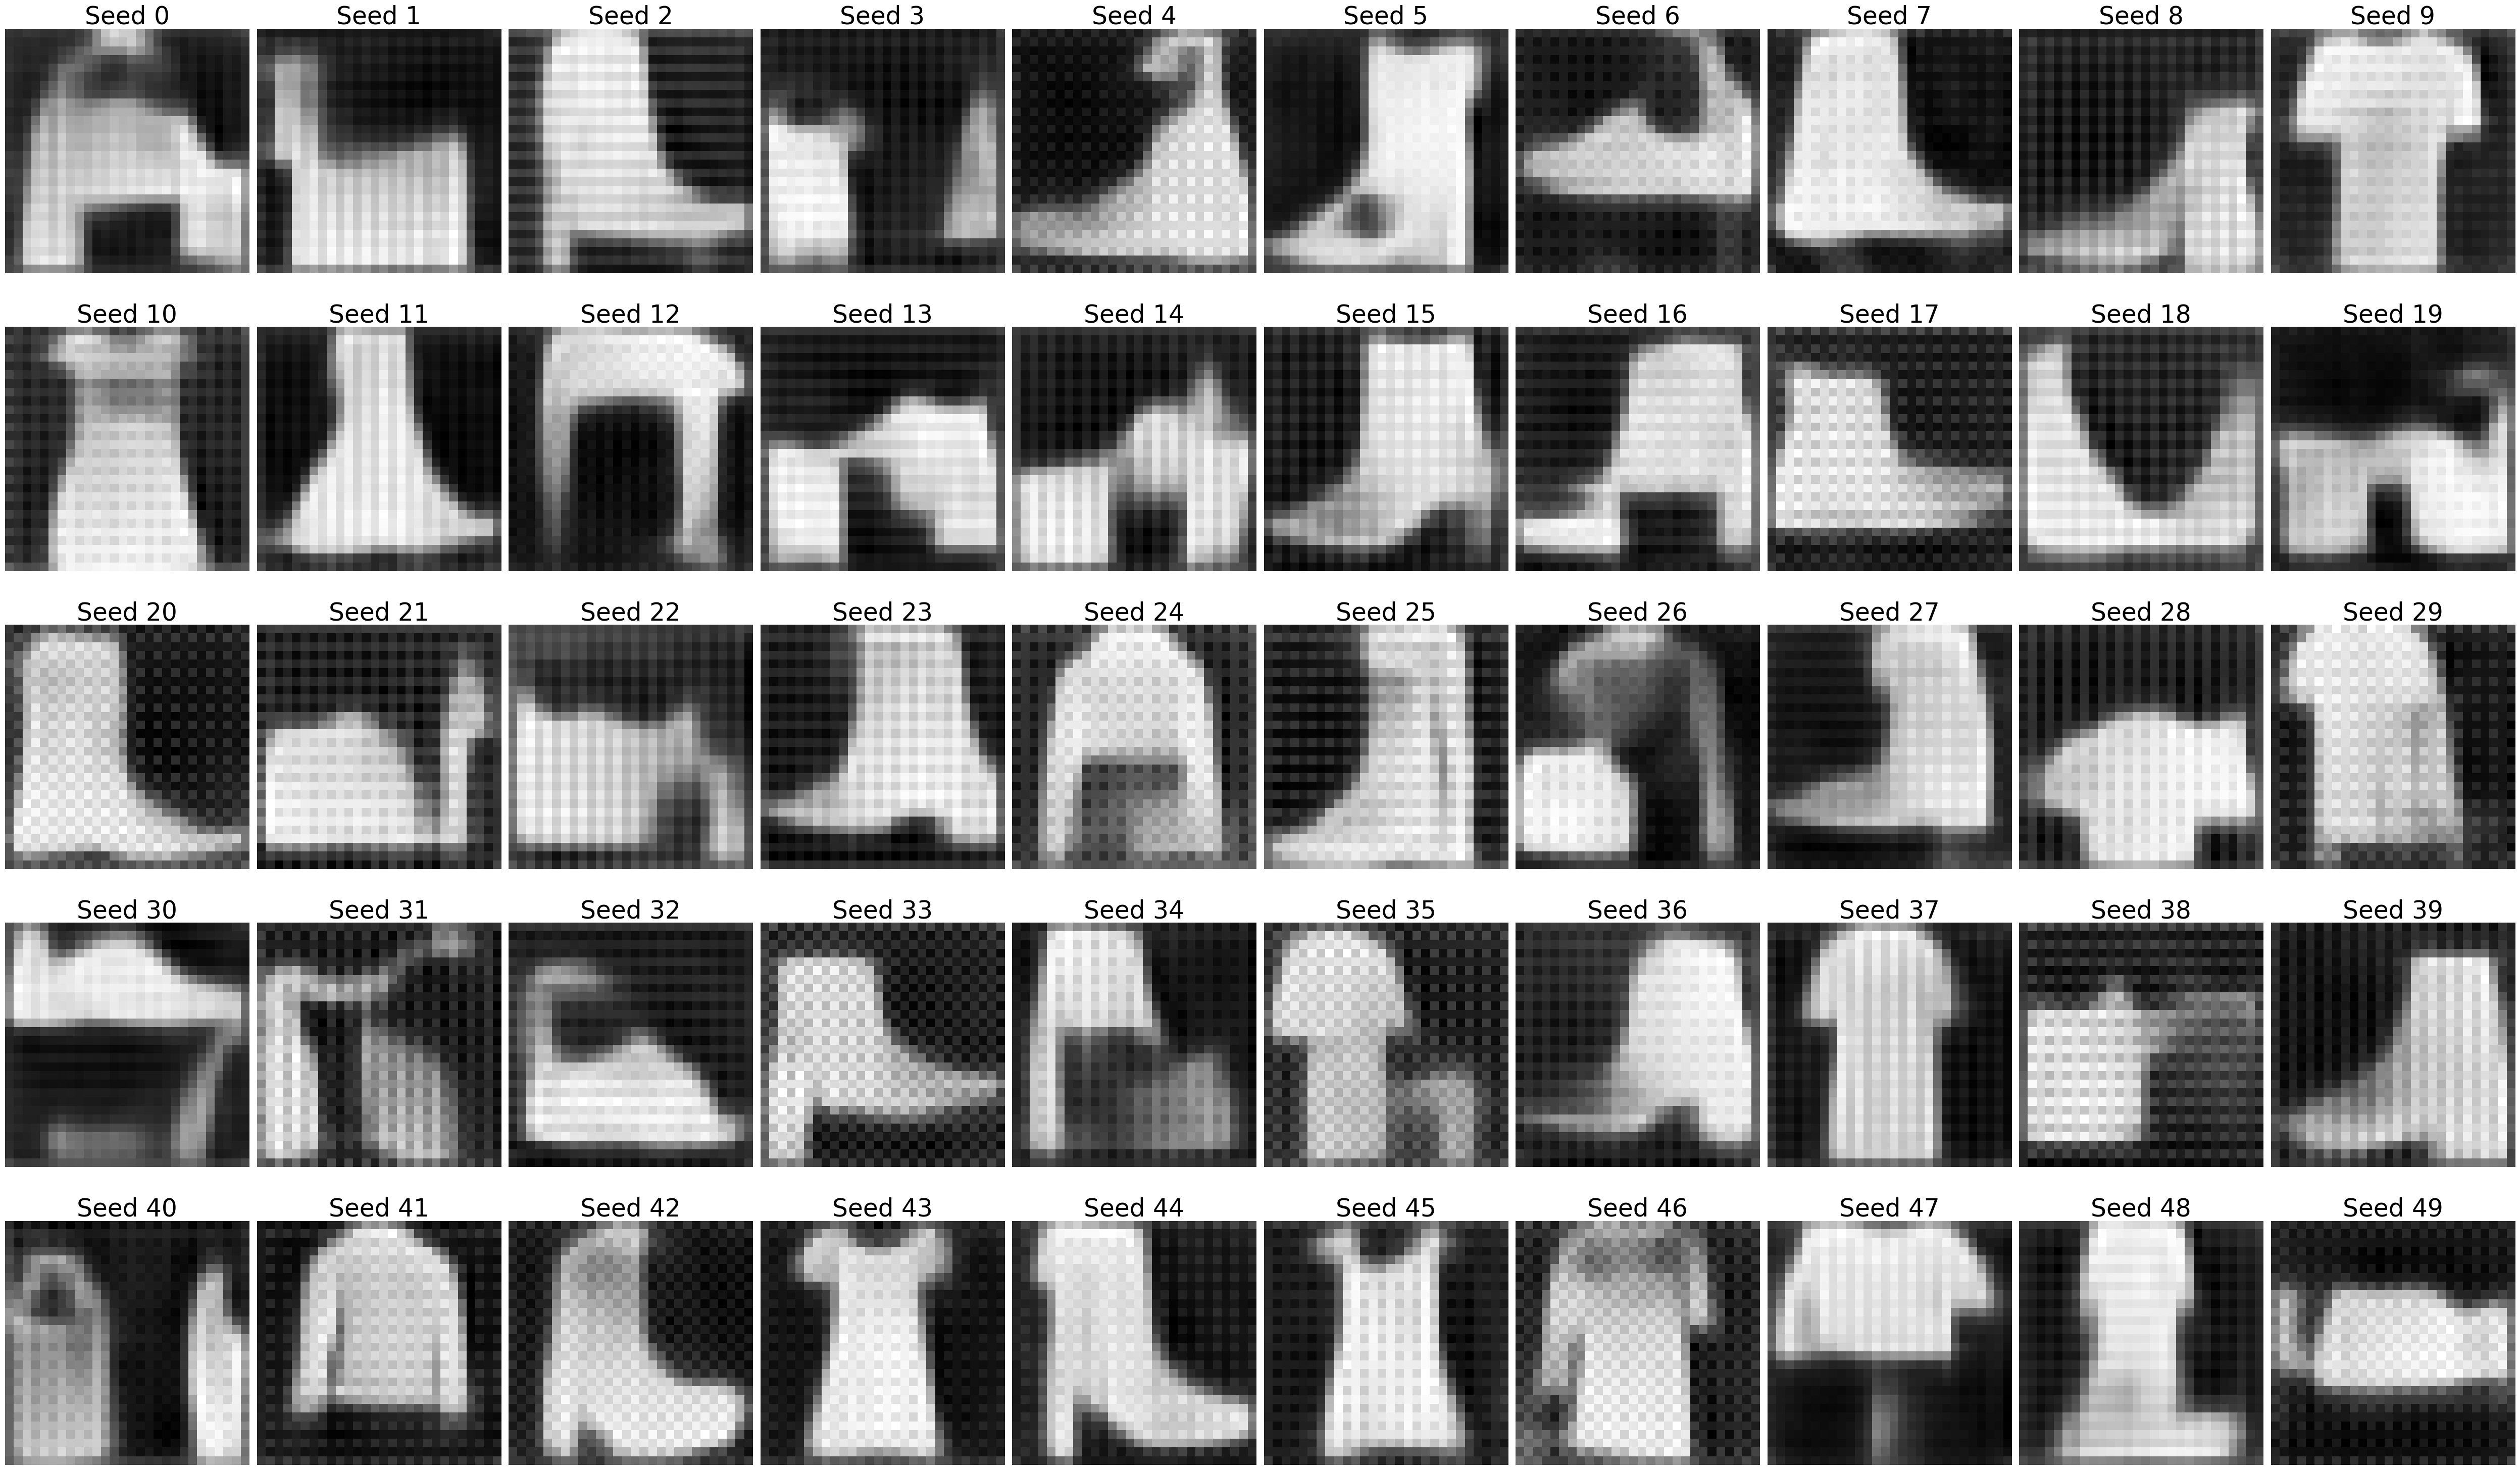

In [ ]:
# Code for the plotting of samples goes here
# Number of figures
n_figures = 50

# Setup the subplot grid
n_rows = 5
n_cols = n_figures // n_rows

# Create a figure and an array of axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(50, 30))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

for i in range(n_figures):
    # Example plot: a line graph
    torch.cuda.manual_seed(i)
    sample_1 = sample(model_su, [1, 1, 28, 28])
    axs[i].imshow(sample_1[-1].reshape(28, 28), cmap="gray")
    axs[i].set_title(f'Seed {i}', fontsize=35)
    axs[i].axis("off")

# Adjust layout so titles and labels don't overlap
plt.tight_layout()

# Display the figure
plt.show()

Include your best generated samples below.

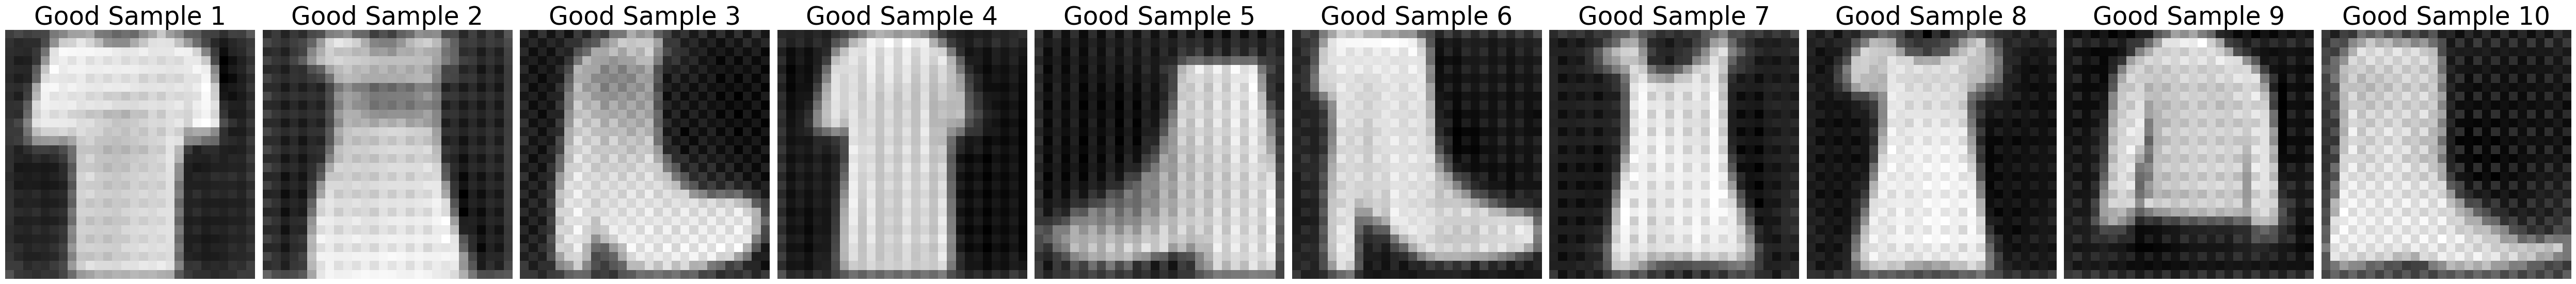

In [ ]:
# Code to show the best samples goes here
# Hand-picked list
best_seeds = [9, 10, 42, 37, 39, 44, 45, 43, 41, 20]
# Number of figures
n_figures = 10

# Setup the subplot grid
n_rows = 1
n_cols = n_figures // n_rows

# Create a figure and an array of axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(50, 6))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

for i in range(n_figures):
    # Example plot: a line graph
    torch.cuda.manual_seed(best_seeds[i])
    sample_1 = sample(model_su, [1,1,28,28])
    axs[i].imshow(sample_1[-1].reshape(28, 28), cmap="gray")
    axs[i].set_title(f'Good Sample {i+1}', fontsize=35)
    axs[i].axis("off")
# Adjust layout so titles and labels don't overlap
plt.tight_layout()

# Display the figure
plt.show()

Our good sample include some tshirts, jumper, frocks and shoes.

Include your most efficient implementation details below.

For this, I use a model which uses a down channel list of $(16,32,64)$, up channel list of $(64,32,16)$, time_emb_dim of $16$. I also define a bottleneck after downsampling and before upsampling, which enhances feature extraction in the UNet. The training time and number of parameters are printed at the bottom of the output of the next cell.

In [17]:
# Code to make your most efficient setup goes here; present all code from above in one Code block
# run it to show final runtimes and print out the total number of parameters in the model.

class Bottleneck(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        '''
        in_ch refers to the number of channels in the input to the operation and out_ch how many should be in the output
        '''
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        time_emb = self.time_mlp(t)
        time_emb = self.relu(time_emb)
        # print(x.shape, time_emb.shape)
        x = self.conv1(x)
        # print(x.shape, time_emb.shape)
        x = self.relu(x)
        # print(x.shape, time_emb.shape)
        x = self.bnorm1(x)

        x = x + time_emb.unsqueeze(-1).unsqueeze(-1)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bnorm2(x)
        return x
class SimpleUnetEff(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (16, 32, 64) # These are the channels that we want to obtain in the downsampling stage; DEFINE YOURSELF!
        up_channels = (64, 32, 16) # These are the channels that we want to obtain in the upsampling stage; DEFINE YOURSELF!
        out_dim = 1 # DEFINE THIS CORRECTLY
        time_emb_dim = 16 # DEFINE THIS CORRECTLY

        # Time embedding consists of a Sinusoidal embedding, a linear map that maintains the dimensions and a rectified linear unit activation.
        # TO WRITE CODE
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection consisting of a map from image_channels to down_channels[0] with a filter size of e.g. 3 and padding of 1.
        # TO WRITE CODE
        self.initial_projection = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=1)

        # Downsample: use the Blocks given above to define down_channels number of downsampling operations. These operations should cha
        # TO WRITE CODE HERE; HINT: use something like Block(down_channels[i], down_channels[i+1], time_emb_dim) the right number of times.
        self.downsample = nn.ModuleList()
        for i in range(len(down_channels) - 1):
            self.downsample.append(Block(down_channels[i], down_channels[i+1], time_emb_dim))

        # Create bottleneck
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.bottleneck = Bottleneck(down_channels[-1], 2*up_channels[0], time_emb_dim)
        self.convtranspose = nn.ConvTranspose2d(2*down_channels[-1], down_channels[-1], 4, stride=2, padding=1)
        # Upsample
        # TO WRITE CODE HERE; same logic as the downsample
        self.upsample = nn.ModuleList()
        for i in range(len(up_channels) - 1):
            self.upsample.append(Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True))

        # Final output: given by a final convolution that maps up_channels[-1] to out_dim with a kernel of size 1.
        # TO WRITE CODE
        self.final_conv = nn.Conv2d(up_channels[-1], out_dim, kernel_size=1)

    def forward(self, x, timestep):
        # Embedd time
        t_emb = self.time_embedding(timestep)
        # Initial projection
        x = self.initial_projection(x)

        # Calculate padding
        pad_height = 2
        pad_width = 2
        # Apply symmetric padding
        x = F.pad(x, (pad_width, pad_width, pad_height, pad_height), mode='constant', value=0)

        # Downsampling
        skip_connections = []
        for block in self.downsample:
            x= block(x, t_emb)
            skip_connections.append(x)

        # Apply bottleneck
        x = self.avgpool(x)
        x = self.bottleneck(x, t_emb)
        x = self.convtranspose(x)

        for block in self.upsample:
            residual = skip_connections.pop()
            pad_dim = (1, 0, 1, 0, 0, 0, 0, 0)
            if residual.shape != x.shape:
              x = torch.nn.functional.pad(x, pad_dim)

            x = torch.cat((x, residual), dim=1)
            x = block(x, t_emb)
        # Final convolution
        x = self.final_conv(x)
        # Crop back to original dimensions
        center_crop = transforms.CenterCrop((28, 28))
        x = center_crop(x)
        return x

model_eff = SimpleUnetEff()
optimizer_eff = Adam(model_eff.parameters(), lr=0.001)
model_eff.train()
model_eff.to(device)
train_start = time.time()
for epoch in range(20):
      for batch in tqdm(dataloader):
          batch = batch["pixel_values"].to(device)
          timesteps = torch.randint(0, T, (BATCH_SIZE,)).to(device)
          optimizer_eff.zero_grad()
          loss = get_loss(model_eff, batch, timesteps)
          loss.backward()
          optimizer_eff.step()
      # Print loss of final batch in epoch
      print(f"Epoch {epoch+1} Loss: {loss.item()}")
train_end = time.time()
# TRAINING TIME AND NO. OF PARAMS PRINTED AT BOTTOM
print(f"Training Loop Time Taken in Seconds: {train_end - train_start}")
print(f"Total Number of Parameters in the Model: {sum(p.numel() for p in model_eff.parameters() if p.requires_grad)}")

100%|██████████| 468/468 [00:20<00:00, 22.48it/s]


Epoch 1 Loss: 0.0830833688378334


100%|██████████| 468/468 [00:19<00:00, 23.43it/s]


Epoch 2 Loss: 0.07896284759044647


100%|██████████| 468/468 [00:18<00:00, 24.81it/s]


Epoch 3 Loss: 0.07199563831090927


100%|██████████| 468/468 [00:19<00:00, 24.00it/s]


Epoch 4 Loss: 0.07459495961666107


100%|██████████| 468/468 [00:29<00:00, 15.69it/s]


Epoch 5 Loss: 0.06659232079982758


100%|██████████| 468/468 [00:21<00:00, 22.18it/s]


Epoch 6 Loss: 0.07328017801046371


100%|██████████| 468/468 [00:21<00:00, 21.81it/s]


Epoch 7 Loss: 0.06165118142962456


100%|██████████| 468/468 [00:19<00:00, 24.55it/s]


Epoch 8 Loss: 0.0676078274846077


100%|██████████| 468/468 [00:19<00:00, 23.75it/s]


Epoch 9 Loss: 0.06485986709594727


100%|██████████| 468/468 [00:18<00:00, 25.06it/s]


Epoch 10 Loss: 0.07723270356655121


100%|██████████| 468/468 [00:19<00:00, 24.56it/s]


Epoch 11 Loss: 0.06425856798887253


100%|██████████| 468/468 [00:19<00:00, 24.08it/s]


Epoch 12 Loss: 0.058828677982091904


100%|██████████| 468/468 [00:19<00:00, 24.41it/s]


Epoch 13 Loss: 0.05877295508980751


100%|██████████| 468/468 [00:22<00:00, 21.13it/s]


Epoch 14 Loss: 0.05461753159761429


100%|██████████| 468/468 [00:18<00:00, 25.38it/s]


Epoch 15 Loss: 0.07135827094316483


100%|██████████| 468/468 [00:19<00:00, 24.46it/s]


Epoch 16 Loss: 0.06123718246817589


100%|██████████| 468/468 [00:19<00:00, 24.13it/s]


Epoch 17 Loss: 0.06671901792287827


100%|██████████| 468/468 [00:18<00:00, 25.25it/s]


Epoch 18 Loss: 0.058527301996946335


100%|██████████| 468/468 [00:19<00:00, 24.39it/s]


Epoch 19 Loss: 0.05796459689736366


100%|██████████| 468/468 [00:19<00:00, 24.62it/s]


Epoch 20 Loss: 0.05964092165231705
Training Loop Time Taken in Seconds: 402.76902770996094
Total Number of Parameters in the Model: 588289


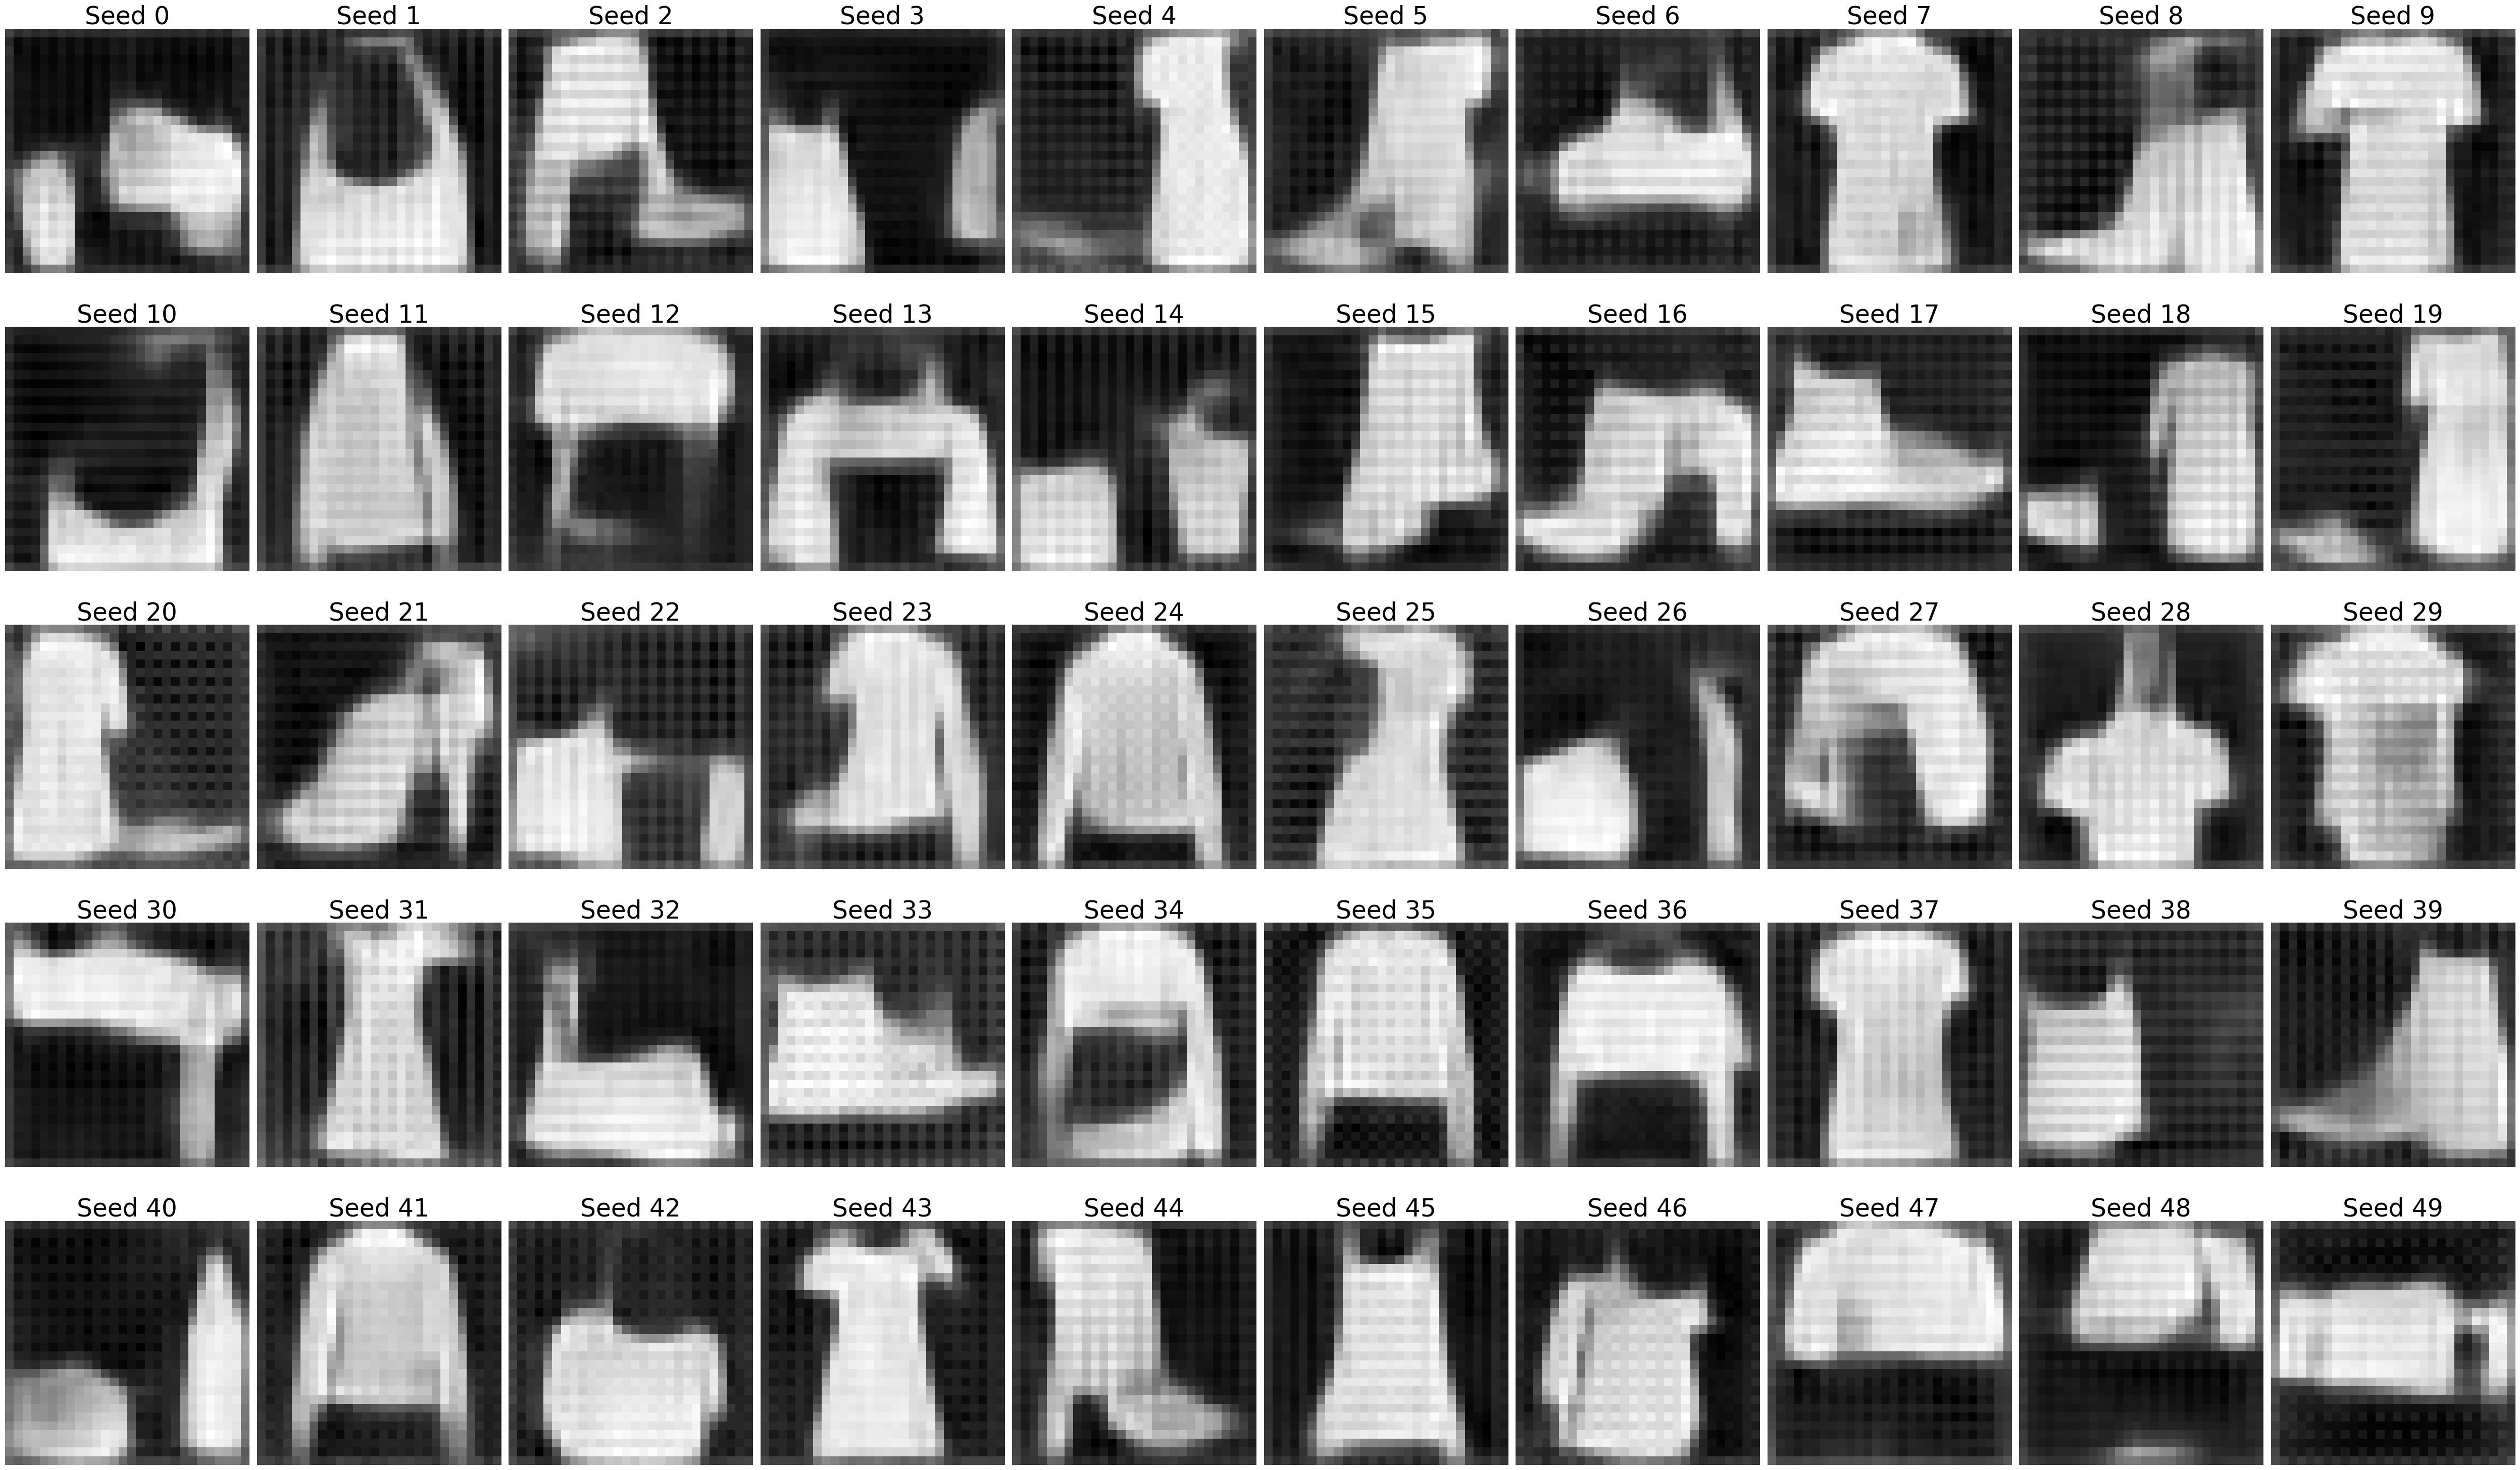

In [18]:
# Code for the plotting of samples goes here
# Number of figures
n_figures = 50

# Setup the subplot grid
n_rows = 5
n_cols = n_figures // n_rows

# Create a figure and an array of axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(50, 30))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

for i in range(n_figures):
    # Example plot: a line graph
    torch.cuda.manual_seed(i)
    sample_1 = sample(model_eff, [1, 1, 28, 28])
    axs[i].imshow(sample_1[-1].reshape(28, 28), cmap="gray")
    axs[i].set_title(f'Seed {i}', fontsize=35)
    axs[i].axis("off")

# Adjust layout so titles and labels don't overlap
plt.tight_layout()

# Display the figure
plt.show()

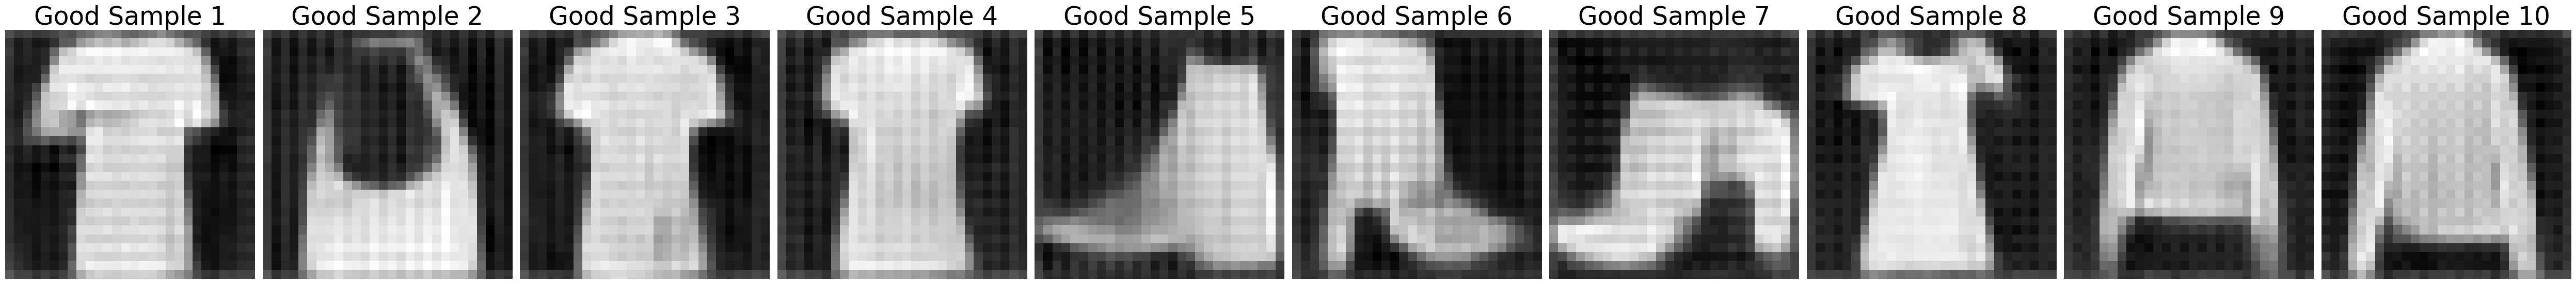

In [22]:
# Code to show the best samples goes here
# Hand-picked list
best_seeds = [9, 1, 7, 37, 39, 44, 16, 43, 41, 24]
# Number of figures
n_figures = 10

# Setup the subplot grid
n_rows = 1
n_cols = n_figures // n_rows

# Create a figure and an array of axes
fig, axs = plt.subplots(n_rows, n_cols, figsize=(50, 6))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

for i in range(n_figures):
    # Example plot: a line graph
    torch.cuda.manual_seed(best_seeds[i])
    sample_1 = sample(model_eff, [1,1,28,28])
    axs[i].imshow(sample_1[-1].reshape(28, 28), cmap="gray")
    axs[i].set_title(f'Good Sample {i+1}', fontsize=35)
    axs[i].axis("off")
# Adjust layout so titles and labels don't overlap
plt.tight_layout()

# Display the figure
plt.show()

Interpretation of your results goes here.

Epoch 1 Loss: 0.07574652135372162
Epoch 2 Loss: 0.0659438967704773
Epoch 3 Loss: 0.06649383902549744
Epoch 4 Loss: 0.06997711211442947
Epoch 5 Loss: 0.0680033341050148
Epoch 6 Loss: 0.06437988579273224
Epoch 7 Loss: 0.0470469668507576
Epoch 8 Loss: 0.06536213308572769
Epoch 9 Loss: 0.05177290365099907
Epoch 10 Loss: 0.06117153912782669
Epoch 11 Loss: 0.06702101230621338
Epoch 12 Loss: 0.06159483641386032
Epoch 13 Loss: 0.06897883862257004
Epoch 14 Loss: 0.07275716215372086
Epoch 15 Loss: 0.05719541013240814
Epoch 16 Loss: 0.05931004136800766
Epoch 17 Loss: 0.06549917161464691
Epoch 18 Loss: 0.064287930727005
Epoch 19 Loss: 0.058380238711833954
Epoch 20 Loss: 0.0514926016330719


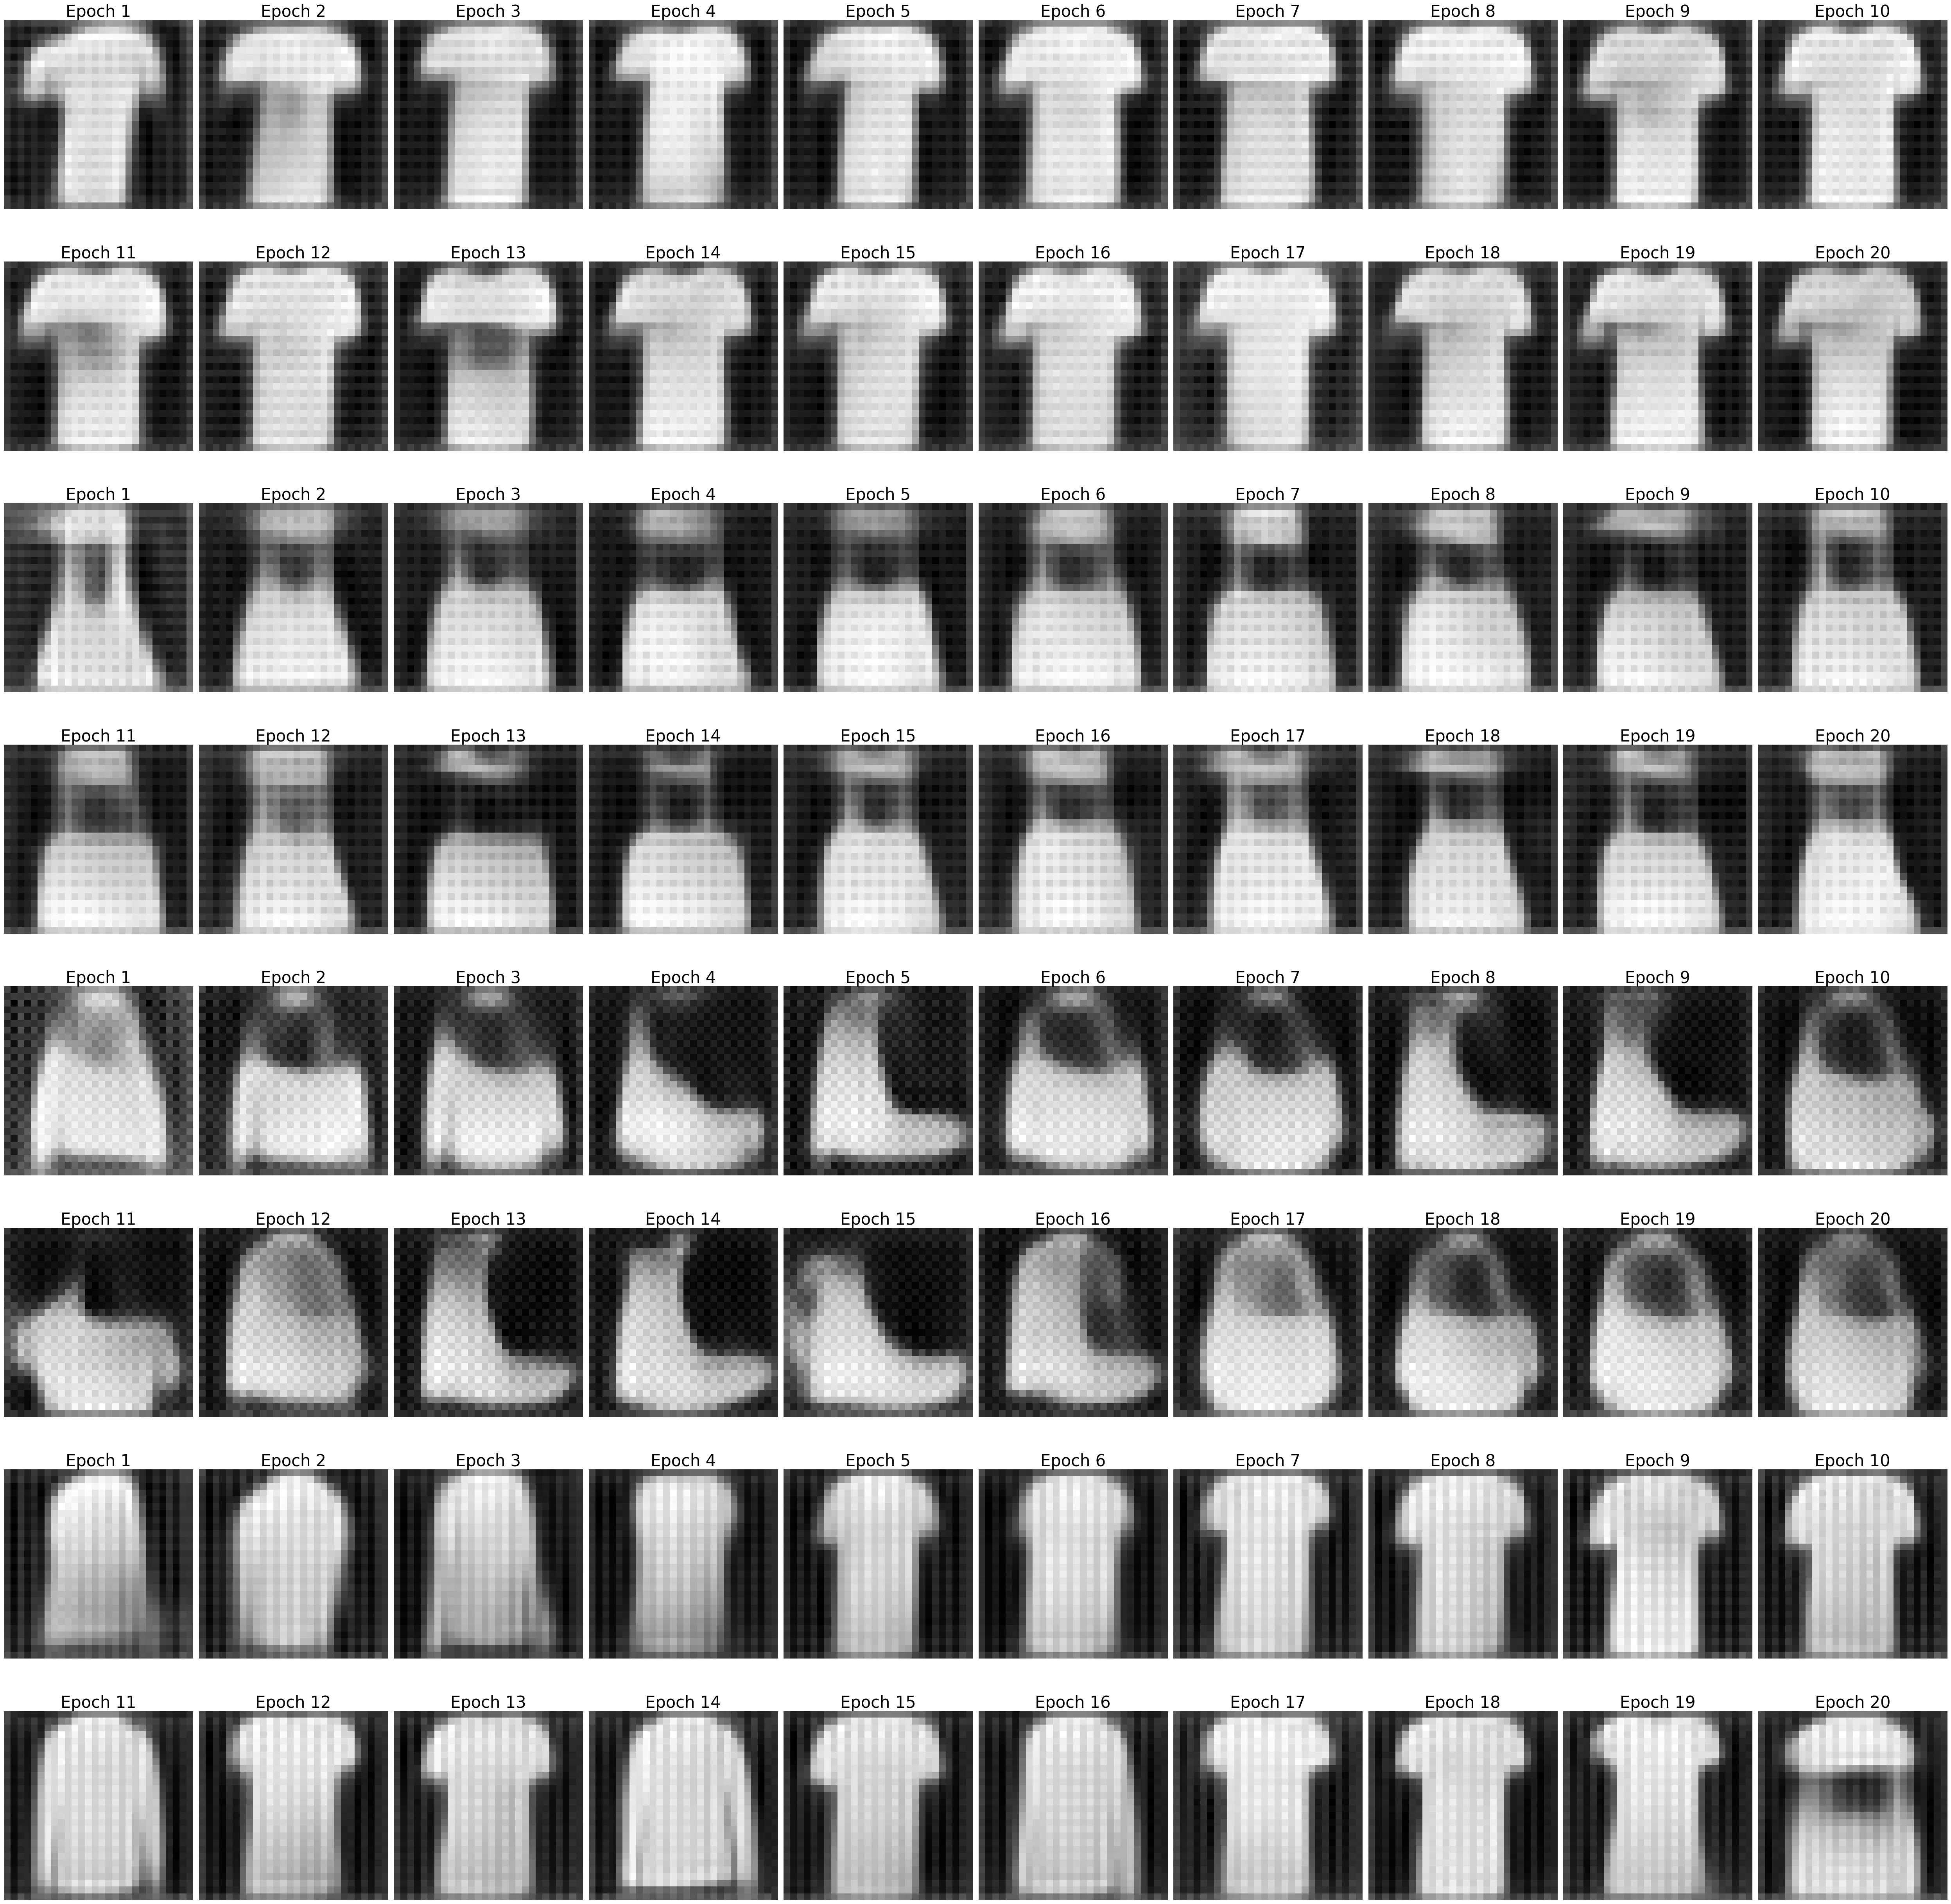

In [25]:
# Here goes the code for visualising during training and add a discussion above.
# Initialise model
model_su = SimpleUnet()
optimizer = Adam(model_su.parameters(), lr=0.001)
model_su.train()
model_su.to(device)
n_epochs = 20
fig, axs = plt.subplots(8, n_epochs // 2, figsize = (50,50))
axs = axs.flatten()
for epoch in range(n_epochs):
      for batch in tqdm(dataloader, disable=True):
          batch = batch["pixel_values"].to(device)
          timesteps = torch.randint(0, T, (BATCH_SIZE,)).to(device)
          optimizer.zero_grad()
          loss = get_loss(model_su, batch, timesteps)
          loss.backward()
          optimizer.step()
      # Set seed so same noise is guarenteed at each step
      torch.cuda.manual_seed(9)
      sample_1 = sample(model_su, [1,1,28,28])
      axs[epoch].imshow(sample_1[-1].reshape(28, 28), cmap="gray")
      axs[epoch].set_title(f'Epoch {epoch+1}', fontsize=30)
      axs[epoch].axis("off")
      torch.cuda.manual_seed(10)
      sample_1 = sample(model_su, [1,1,28,28])
      axs[epoch + 20].imshow(sample_1[-1].reshape(28, 28), cmap="gray")
      axs[epoch + 20].set_title(f'Epoch {epoch+1}', fontsize=30)
      axs[epoch + 20].axis("off")
      torch.cuda.manual_seed(42)
      sample_1 = sample(model_su, [1,1,28,28])
      axs[epoch + 40].imshow(sample_1[-1].reshape(28, 28), cmap="gray")
      axs[epoch + 40].set_title(f'Epoch {epoch+1}', fontsize=30)
      axs[epoch + 40].axis("off")
      torch.cuda.manual_seed(37)
      sample_1 = sample(model_su, [1,1,28,28])
      axs[epoch + 60].imshow(sample_1[-1].reshape(28, 28), cmap="gray")
      axs[epoch + 60].set_title(f'Epoch {epoch+1}', fontsize=30)
      axs[epoch + 60].axis("off")
      print(f"Epoch {epoch+1} Loss: {loss.item()}")
plt.tight_layout()
plt.show()

In the figure above, we see how $4$ different samples are obtained from a model after $n$ many epochs $(n \in \{1,2,3...,20\})$. \\
For the first sample (the half sleeve t-shirt), after $1$ epoch, the image is slightly crooked but then straightens from the second epoch onwards. This tell us that the model learns the orientation of objects very early on. \\
The third sample is an interesting one as the model initially forms a hand bag, then a shoe, and it alternates between these two for some epochs. As the epochs progress, the model refines the details within the shape. The edges become sharper and the internal structures become more defined. This indicates that the deeper layers of the network are starting to capture finer and niche details. There might be epochs where the shape looks slightly less defined than in the previous one. This could be due to the model exploring different feature spaces (shoes) or due to the batch variance during training. \\
Another interesting sample is the fourth one, where the tshirt is sampled in some epochs and a jumper in the other epochs. Maybe one reason for this is that the model has not determined the most important features yet and is slightly unstable because we cannot say for sure that the model has converged (the $20^{th}$ epoch almost looks like a handbag).

In [ ]:
# Code to save and load models
# Code not needed anymore - just there in case
torch.save(model_su.state_dict(), "model_su_32,64,128_20_epochs.pth")
from google.colab import files
model_path = 'model_su_32,64,128_20_epochs.pth'
files.download(model_path)
model_su_saved = SimpleUnet()
model_su_saved.load_state_dict(torch.load("model_su_32,64,129_11_epochs.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Part 3. On DeepDream [5 points]

In this task we will implement a DeepDream model in order to generate ‘dreams’: images enhanced by the neural network.

Here we will work with a pre-trained model (Inception-V3). The idea is as follows: we will load some image (you can later on choose to load your own image if you want). We will load the Inception-V3 model. We will pass it an input and obtain the activation outputs from a certain layer. We will 'ask' the neural network to maximise the values of the activation, i.e. enhance the image with what those layer activations 'like' to see. For this we will implement a gradient ascent method in order to maximise a norm of the activations over that input. This will change our input into a `dream'.

1. [1 point] Write a piece of code that will load the Inception-V3 model and allow you to get access to the intermediate activations.

2. [2 points] Implement the deepdream optimisation loop. We will use gradient ascent to optimise for the norm of the activation. Implement a function that performs this gradient ascent. This function will take as input the number of iterations to perform, the learning rate, and the start image (i.e. the image which the model will enhance). Define in the function a for loop over the number of iterations, obtain the model output, get the output of the hook (hint: use something like `outputs[-1]`), compute the loss which will be L2 norm of this output (i.e. the L2 norm of the activations from your chosen layer), compute the gradients of this L2 norm loss, scale the gradients by their absolute average (hint: scale using `torch.abs(g).mean()`) and define a gradient ascent step over the image. Do not forget to zero out gradients where needed.

3. [1 point] Implement code to load an image (e.g. https://github.com/pytorch/hub/raw/master/images/dog.jpg) and display the output from your optimisation loop (using e.g. numpy). Present the generated images for different choices of layer activations and different number of optimisation steps. Discuss your results. What is the impact of using different layers? What is the impact of the number of optimisation steps? [0.5 point will be given for the implementation and 1.5 point for a very good discussion]

4. [1 point] In our previous setting we allowed for optimising for a single layer's activation. Change the method such that it will allow to compute the loss (L2 norm) of multiple layers' outputs. Present three different setups using different numbers & combinations of layers and discuss your results in max. 3 lines.

In [3]:
# Part 3.1
# Load the trained model
model = models.inception_v3(pretrained=True)
model.eval()

# Access activations
def get_activation(layer):
    def hook(model, input, output):
        layer.output = output
    return hook

# Choose a layer to obtain intermediate activations from
layer_name = 'Mixed_7a'
layer = model._modules.get(layer_name)
hook = layer.register_forward_hook(get_activation(layer))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 80.2MB/s]


In [4]:
# Part 3.2
def deepdream(model, image, layer, iters, lr):
    # List to store the outputs of the desired layer
    outputs= []
    def hook(module, input, output):
      outputs.append(output)
    # Obtaining the output from the desired layer and appending to outputs
    h = layer.register_forward_hook(hook)
    image.requires_grad_(True)
    for i in range(iters):

        model.zero_grad()
        # Forward pass
        output = model(image)
        # Find L2 norm of this output
        loss = torch.norm(outputs[-1])
        loss.backward()

        grad = image.grad
        grad = grad / torch.abs(grad).mean()
        # Gradient ascent
        image.data += lr * grad
        # Set to zero for next iteration/zero out gradients
        image.grad.zero_()
        # Clear outputs
        outputs.clear()
    # Unregister hook
    h.remove()
    return image.detach().squeeze(0).permute(1,2,0).numpy()

In [5]:
# Part 3.3
# Save image in google files first
# Then open it
image_path = "dog.jpg"
image = Image.open(image_path)

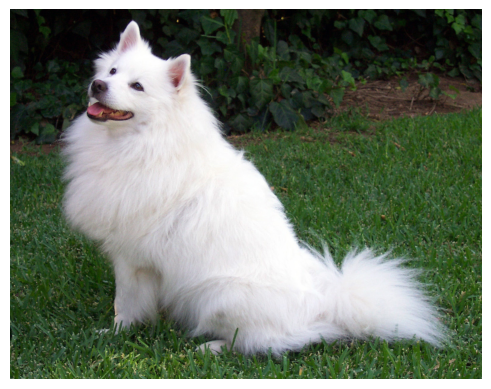

In [6]:
plt.imshow(image)
plt.axis("off")
plt.show()

In [7]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)

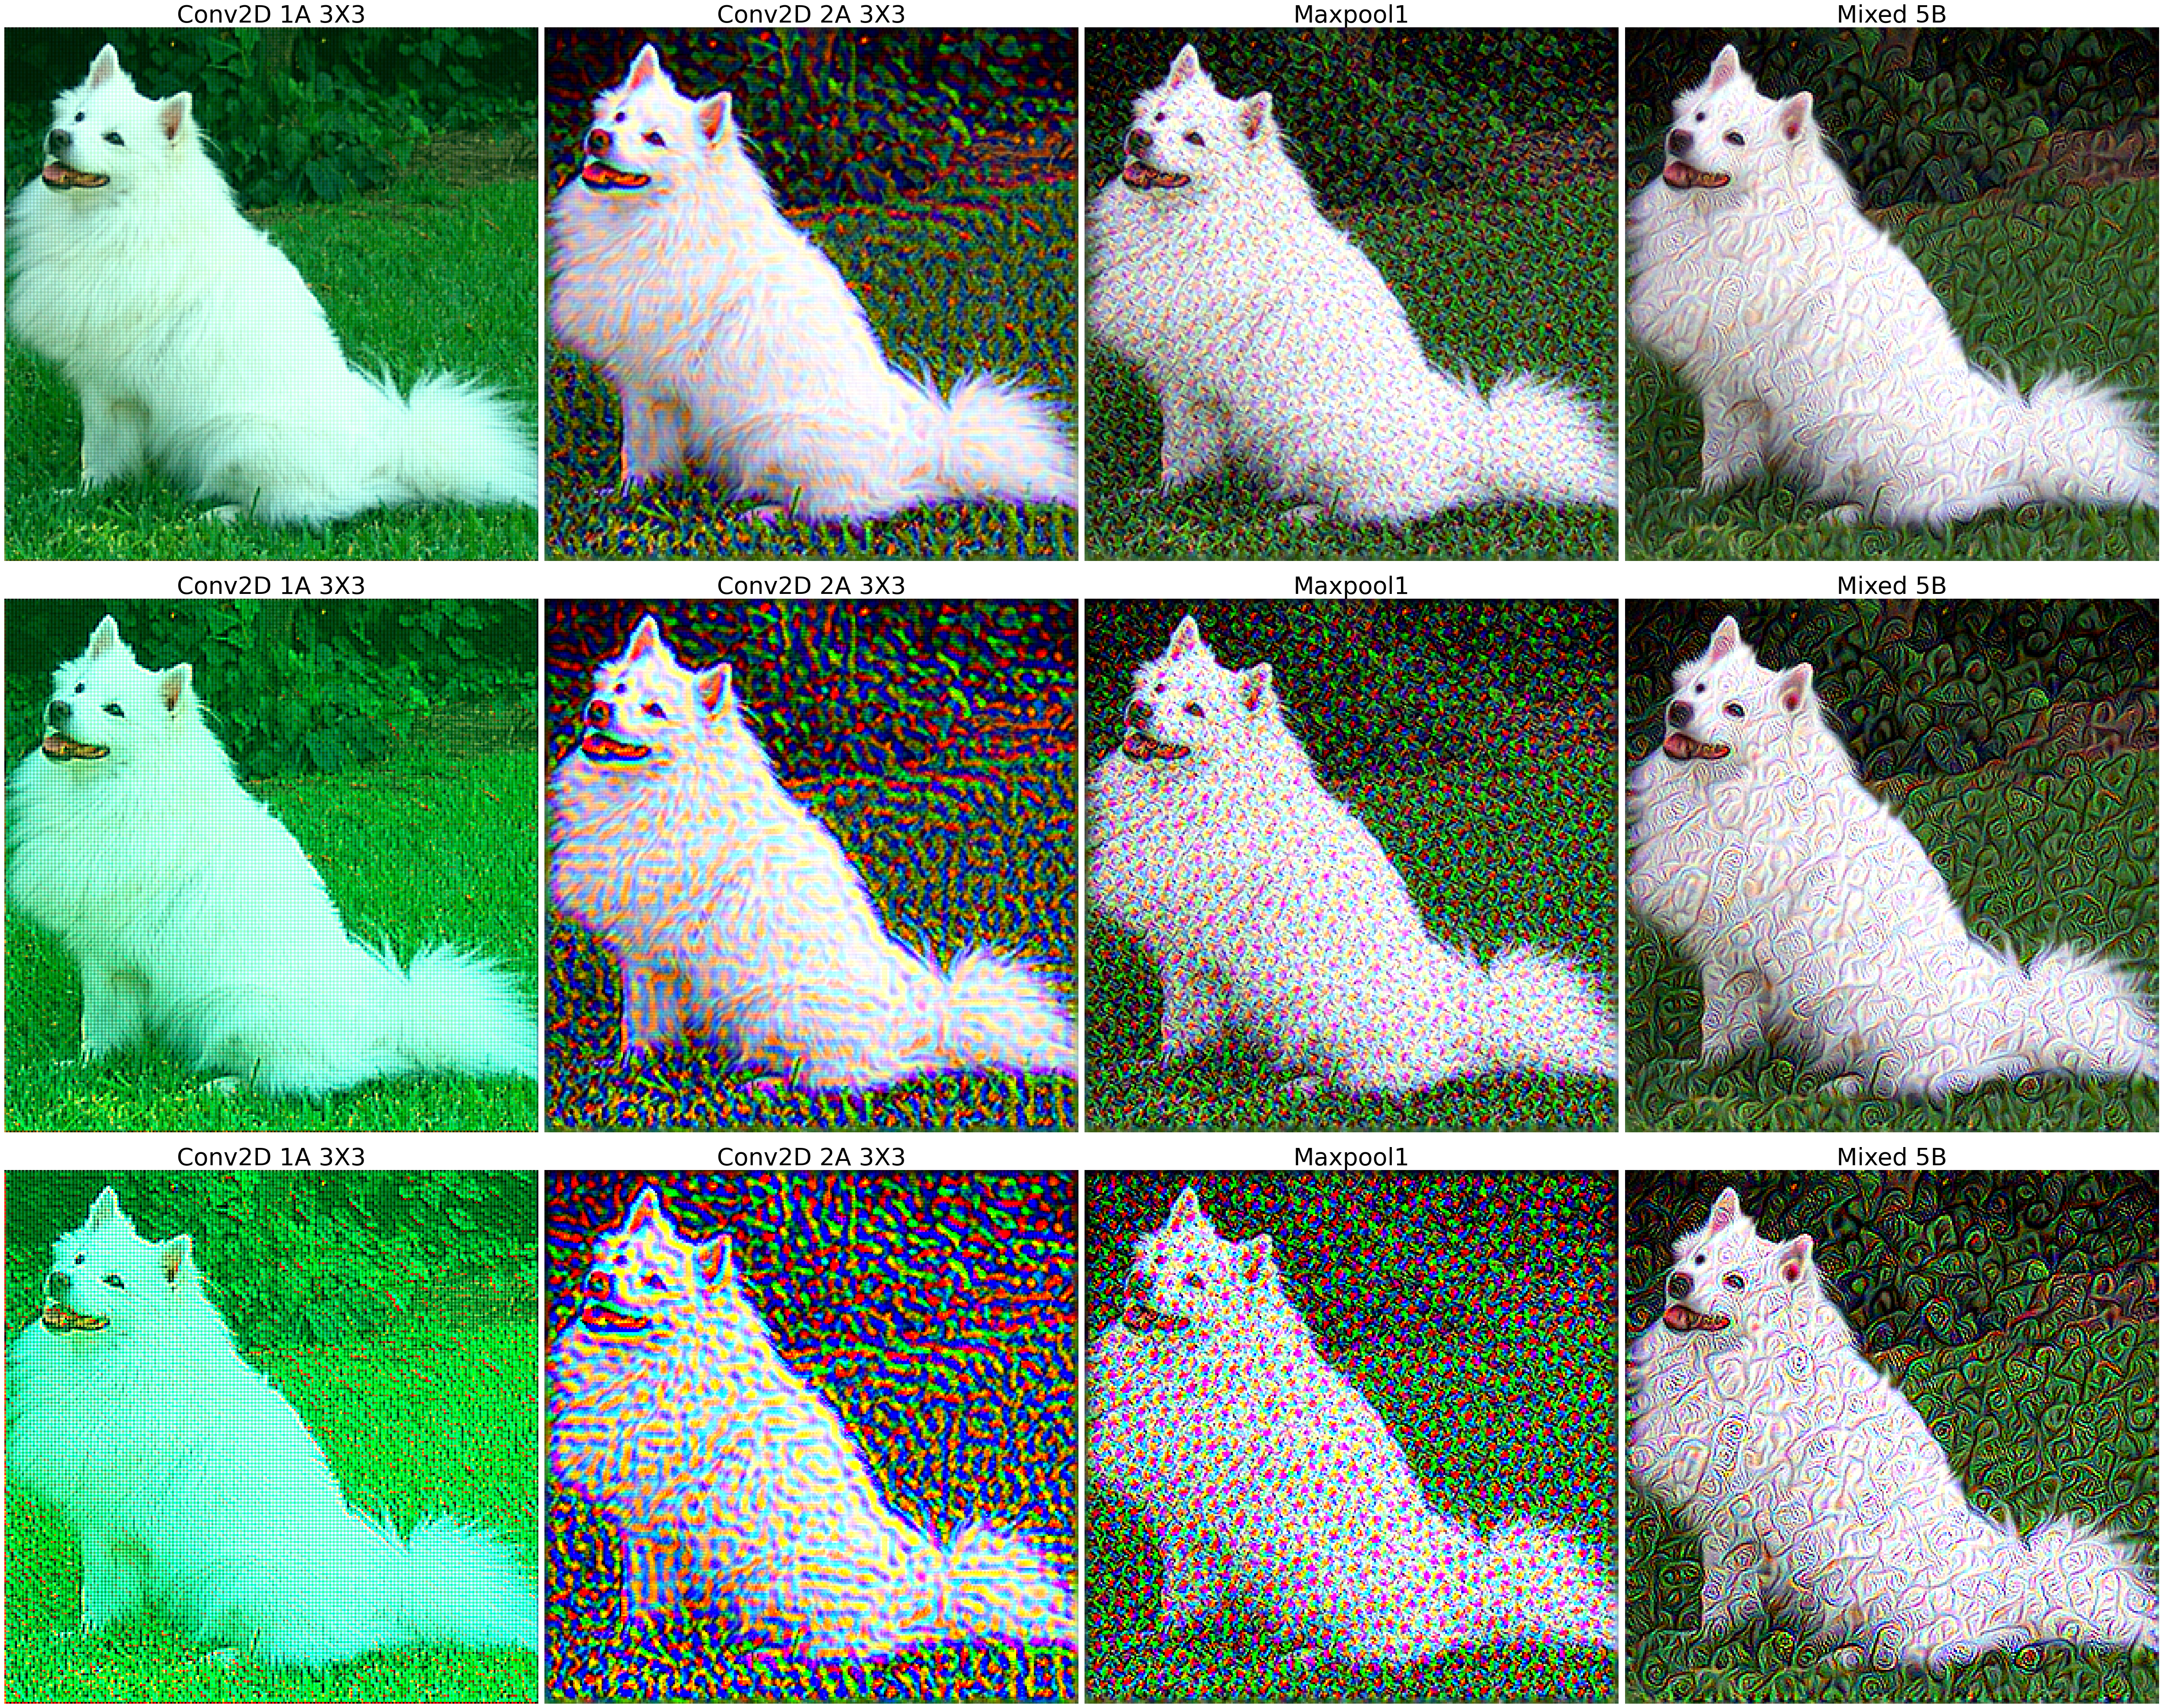

In [ ]:
layer_names = [
    'Conv2d_1a_3x3', 'Conv2d_2a_3x3', 'maxpool1', 'Mixed_5b'
]

# Visualize the DeepDream outputs
steps = [5, 10, 20]
fig, ax = plt.subplots(len(steps), len(layer_names), figsize=(50, 40))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i, layer_name in enumerate(layer_names):
    layer = dict([*model.named_modules()])[layer_name]

    for j in range(len(steps)):
        # Preprocess your input image and convert to batch format
        input_image = image
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)
        output = deepdream(model, input_batch, layer, steps[j], 0.1)

        # Post-process the output
        # Apply normalization inversely
        output = output * std + mean
        output = output.clip(0, 1)


        # Display the image
        ax[j][i].imshow(output)
        ax[j][i].set_title(layer_name.replace('_', ' ').title(), fontsize=40)
        ax[j][i].axis('off')


plt.tight_layout()
plt.show()

As we go down a column, we see the effect of using a different number of optimisation steps ($5$, $10$ and $20$). As we go across a row, we see the effect of different layers applied to the image. If we consider the layer Conv 2D 2A 3x3, in $5$ steps, the resulting image splits the background into tiny pieces with enhanced colours, using a $3\times3$ filter. As the number of steps increases the pattern converges all across the image (onto the dog as well). With the maxpool1 layer, we would expect a more abstract representation of the images as max pooling works by taking the maximum value of each window. However, after 20 steps, it seeems that applying this layer multiple times overfits the image and we just see a consistent pattern across the image. With all images, we see that applying $20$ optimisation steps makes the respective pattern more consisten throughout the image, therefore losing any structural insights on the data. \\
Conv 2D 1A 3x3 does a good job in brightening the image. The filter used in this layer does a good job of taking the non-bright background and applied some sort of inverse weighted filter to increase the intensity of the background. As we increase the optimisation steps, the dog itself becomes less intense. By combining convolutions of different sizes (e.g. $1\times1$, $3\times3$, $5\times5$ convolutions) and pooling operations, Mixed 5B creates some complex trends on the image, which makes it somewhat "dreamy".

In [8]:
# Part 3.4
def deepdream_multiple(model, image, layers, iters, lr):
    # List to store the outputs of each desired layer
    outputs = []

    # Register a forward hook for each layer
    hooks = []
    for layer in layers:
        hook = layer.register_forward_hook(lambda module, input, output: outputs.append(output))
        hooks.append(hook)

    image.requires_grad_(True)
    for i in range(iters):

        model.zero_grad()
        # Forward pass
        # Dont need to store as calling model itself registers the hook
        _ = model(image)
        # Find L2 norm of this output
        loss = torch.norm(sum(torch.norm(output) for output in outputs))
        loss.backward()

        grad = image.grad
        grad = grad / torch.abs(grad).mean()
        # Gradient ascent
        with torch.no_grad():
            image.data += lr * grad
        # Set to zero for next iteration/zero out gradients
        image.grad.zero_()
        # Clear outputs
        outputs.clear()

    # Remove all the hooks
    for hook in hooks:
        hook.remove()

    return image.detach().squeeze(0).permute(1, 2, 0).numpy()

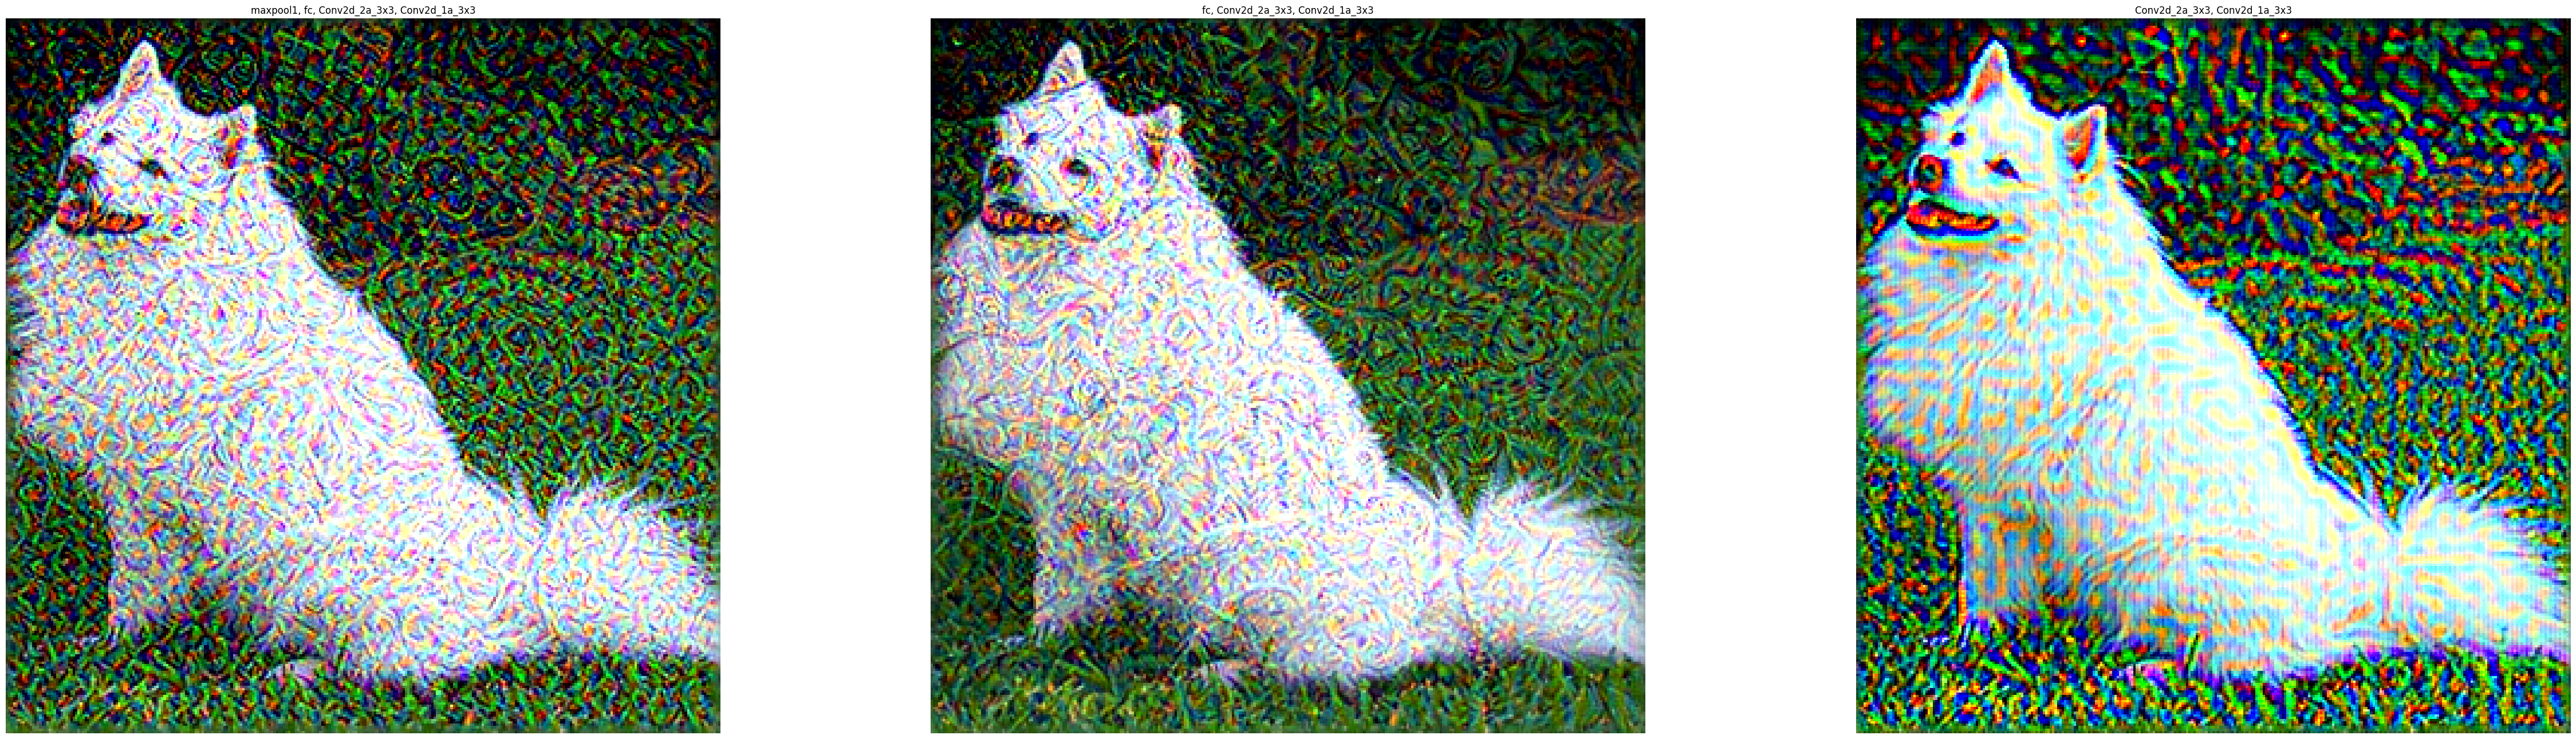

In [10]:
layers =  [model.maxpool1, model.fc, model.Conv2d_2a_3x3, model.Conv2d_1a_3x3]
fig, axs = plt.subplots(1, len(layers) - 1, figsize=(50,13))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i in range(len(layers)-1):
    input_image = image
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    output = deepdream_multiple(model, input_batch, layers[i:], 10, 0.1)
    output = output * std + mean
    axs[i].imshow(output.clip(0,1))
    axs[i].axis('off')
axs[0].set_title("maxpool1, fc, Conv2d_2a_3x3, Conv2d_1a_3x3")
axs[1].set_title("fc, Conv2d_2a_3x3, Conv2d_1a_3x3")
axs[2].set_title("Conv2d_2a_3x3, Conv2d_1a_3x3")
plt.tight_layout()
plt.show()


The first image uses $4$ layers (maxpool1, fc, Conv2d_2a_3x3, Conv2d_1a_3x3), the second image uses $3$ layers (fc, Conv2d_2a_3x3, Conv2d_1a_3x3) and the third image uses $2$ layers (Conv2d_2a_3x3, Conv2d_1a_3x3), all trained using $10$ optimisation steps. In the first and second images, the effects of all individual layers are combined and, specifically in the second image, the effects of each layer can be spotted separately. The third image looks very similar to the previous part with just using the Conv2d_2a_3x3 layer but the intense colours of Conv2d_1a_3x3 are not incorporated as well in all of the images.